# E-Commerce: Product Range Analysis
**Project descritpion**

The goal of the project is to analyze the product range of an online store that sells household goods using exploratory data analysis and statistical hypothesis testing. The insights gained from this analysis can help the store to optimize their product range and improve their sales.

Most probably this task was provided by store owners, marketing teams, or sales teams.

By understanding which products are selling well and which are not, which categories of products are best-sold in different seasons, which time of the day do people prefer to make purchases, the project may help the store to make better decisions to add or remove products from their inventory, adjust pricing for certain products, or target specific marketing campaigns to certain customer segments. The analysis may also help the store to forecast future demand for products and optimize their inventory management.

In this project synamics of sellings and returns of the items will be analyzed, as well as products will be categorized using RFM-approach, helping to identify, which products should be worked on and which should be dropped. Also, the Apriory method will be applied in order to reveal, which products or product bundles are often sold together in order to improve the advertising and offernig systems. More over, statisticall hypotheses of color-sellability and price-sellability effects would be checked as well as seasonability of items sellings.

**Data description**
* `InvoiceNo` — order identifier

* `StockCode` — item identifier

* `Description` — item name

* `Quantity` - quantity of products bought in 1 purchase

* `InvoiceDate` — order date

* `UnitPrice` — price per item

* `CustomerID`

**Additional materials:**

* [**Presentation**](https://disk.yandex.com/i/aRAXiFF0sImjsQ)
* [**Tableau Dashboard**](https://public.tableau.com/app/profile/grigory.perelman/viz/E-CommerceProductRangaanalysis/Dashboard1?publish=yes)

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn.cluster
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import silhouette_score
import nltk
from nltk.tokenize import word_tokenize
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import statsmodels.api as sm
import scipy

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data reading and preprocessing
## Data overwiev

In [3]:
df = pd.read_csv('C:/Users/ADMIN/Downloads/ecommerce_dataset_us.csv', sep = '\t')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


Dataframe consist of 541909 rows of ordered goods. It has missing values in the columns `Description` and `CustomerID`. In the same time, `StockCode` column is full, so `Description` column may be easily recovered, using it. `CustomerID` column will need some special approach to be fixed. This will be studied later. 

In [6]:
print(df.duplicated().sum(),'apparent duplicates detected.')

5268 apparent duplicates detected.


Dropping apparent duplicates:

In [7]:
df = df.drop_duplicates()

Everything is ready to proceed

## Data preprocessing
### Data types

In [8]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

The only column with the datatype problem - `InvoiceDate` - is fixed

Checking the timeperiod of the dataset:

In [9]:
print ( "Start: ", str(df.InvoiceDate.min()))
print ("End: ", str(df.InvoiceDate.max()))
print ("Period: ", str(df.InvoiceDate.max() - df.InvoiceDate.min()))

Start:  2018-11-29 08:26:00
End:  2019-12-07 12:50:00
Period:  373 days 04:24:00


The recorded timeperiod is from 2018-11-29 till 2019-12-07, which is approximatelt a year long: 373 days

### Missing and incorrect values
* **Descriptions**

In [10]:
print('N unique Stock codes:',df.StockCode.nunique(),', N unique Descriptions:',df.Description.nunique())

N unique Stock codes: 4070 , N unique Descriptions: 4223


There is interesting thing in this dataset - number of unique **Descriptions** is bigger, than number of unique **Stock codes**. So, some of the **Descriptions** are different for goods with the same **Stock codes**. I will discover this phenomenon before trying to fix the missing **Descriptions**.

First of all, I will create a neated list, that contains the unique **Stock codes** and all unique **Descriptions**, that appear with this **Code**:

In [11]:
code_descr_list = []
for x in df.StockCode.unique():
    l=[]
    l.append(x)
    l.append((df[df.StockCode == x]['Description'].unique()).tolist())
    code_descr_list.append(l)

In [12]:
code_descr_list[:10]

[['85123A',
  ['WHITE HANGING HEART T-LIGHT HOLDER',
   '?',
   'wrongly marked carton 22804',
   'CREAM HANGING HEART T-LIGHT HOLDER']],
 ['71053', ['WHITE METAL LANTERN', 'WHITE MOROCCAN METAL LANTERN']],
 ['84406B',
  ['CREAM CUPID HEARTS COAT HANGER',
   'incorrectly made-thrown away.',
   '?',
   nan]],
 ['84029G', ['KNITTED UNION FLAG HOT WATER BOTTLE', nan]],
 ['84029E', ['RED WOOLLY HOTTIE WHITE HEART.', nan]],
 ['22752', ['SET 7 BABUSHKA NESTING BOXES']],
 ['21730', ['GLASS STAR FROSTED T-LIGHT HOLDER']],
 ['22633', ['HAND WARMER UNION JACK', nan]],
 ['22632', ['HAND WARMER RED POLKA DOT', 'HAND WARMER RED RETROSPOT', nan]],
 ['84879', ['ASSORTED COLOUR BIRD ORNAMENT', 'damaged']]]

Finding how many **Descriptions** correspond to each **Code**: 

In [13]:
code_descr_counts=[]
for i in range(len(code_descr_list)):
    code_descr_counts.append(len(code_descr_list[i][1]))

And visualizing it in the form of histogram:

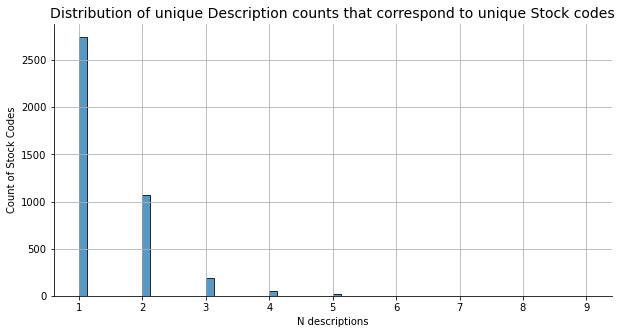

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(code_descr_counts) 
sns.despine()
plt.grid()
plt.title('Distribution of unique Description counts that correspond to unique Stock codes', fontsize = 14)
plt.xlabel('N descriptions')
plt.ylabel('Count of Stock Codes')
plt.show()

More than a half of **Stock Codes** has only one **Description**, so they can be left as they are. Other variants should be analyzed more precisely.

Filtering out only those **Stock codes**, that have more, than 1 description variants:

In [15]:
code_descr_list_to_fix=[]
for i in range(len(code_descr_list)):
    if len(code_descr_list[i][1]) != 1:
        code_descr_list_to_fix.append(code_descr_list[i])
print(len(code_descr_list_to_fix))

1324


Visualizing first 10 of them:

In [16]:
code_descr_list_to_fix[:10]

[['85123A',
  ['WHITE HANGING HEART T-LIGHT HOLDER',
   '?',
   'wrongly marked carton 22804',
   'CREAM HANGING HEART T-LIGHT HOLDER']],
 ['71053', ['WHITE METAL LANTERN', 'WHITE MOROCCAN METAL LANTERN']],
 ['84406B',
  ['CREAM CUPID HEARTS COAT HANGER',
   'incorrectly made-thrown away.',
   '?',
   nan]],
 ['84029G', ['KNITTED UNION FLAG HOT WATER BOTTLE', nan]],
 ['84029E', ['RED WOOLLY HOTTIE WHITE HEART.', nan]],
 ['22633', ['HAND WARMER UNION JACK', nan]],
 ['22632', ['HAND WARMER RED POLKA DOT', 'HAND WARMER RED RETROSPOT', nan]],
 ['84879', ['ASSORTED COLOUR BIRD ORNAMENT', 'damaged']],
 ['84969', ['BOX OF 6 ASSORTED COLOUR TEASPOONS', 'check']],
 ['21777', ['RECIPE BOX WITH METAL HEART', nan]]]

There are different types of problems with **Descriptions**: 
* some of them contain identical values with different colors, like `WHITE HANGING HEART T-LIGHT HOLDER` and `CREAM HANGING HEART T-LIGHT HOLDER`
* some of them have slightly different values, like `HAND WARMER RED POLKA DOT` and `HAND WARMER RED RETROSPOT`
* some of them simply contain *nans*
* some of them contain different causes of the return, like `wrongly marked carton 22804` and `damaged`

The most easy cases are those, which contain *nans* and those, with return causes, as they are written in lowercase, as normal descriptions are written in CAPITAL style.

Firstly I will just drop those descriptions, which are *nans*, written in a lowercase style and equal to '?'

In [17]:
for j in range(10):
    for i in code_descr_list_to_fix:
        for descr in i[1]:
            if descr != descr or any(letter.islower() for letter in descr) or any(letter == '?' for letter in descr):
                i[1].remove(descr)

Visualizyng the new distribution:

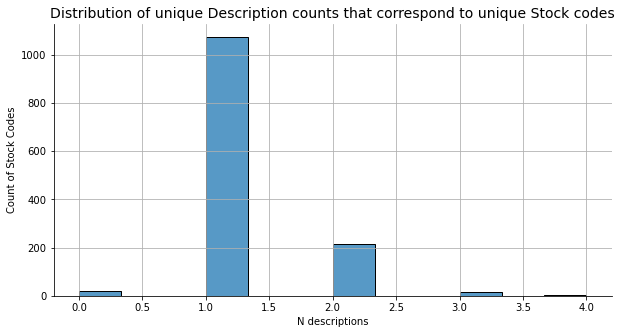

In [18]:
code_descr_counts=[]
for i in range(len(code_descr_list_to_fix)):
    code_descr_counts.append(len(code_descr_list_to_fix[i][1]))
plt.figure(figsize=(10,5))
sns.histplot(code_descr_counts) 
sns.despine()
plt.grid()
plt.title('Distribution of unique Description counts that correspond to unique Stock codes', fontsize = 14)
plt.xlabel('N descriptions')
plt.ylabel('Count of Stock Codes')
plt.show()

As there are many **Stoke codes** with only 1 **Description** now. 

I can filter only them and map as a dictionary to the whole dataset.

There are also some of them, which now have 0 **Descriptions**, that will be needed to check.

Filtering those **Stock Codes**, which now have 1 **Description** and dropping them from the list:

In [19]:
for_dict = []
for j in range(10):
    for i  in code_descr_list_to_fix:
        if len(i[1])==1:
            for_dict.append(i)
            code_descr_list_to_fix.remove(i)

Creating a dictionary:

In [20]:
fixing_dict = { k[0]: k[1][0] for k in for_dict }

Applying this dictionary to map the dataframe:

In [21]:
df.loc[df['StockCode'].isin(fixing_dict.keys()), 'Description'] = df['StockCode'].map(fixing_dict)

In [22]:
print('There are still',len(code_descr_list_to_fix),'goods to be fixed')

There are still 251 goods to be fixed


In [23]:
zero_normal_descr = []
for j in range(10):
    for i  in code_descr_list_to_fix:
        if len(i[1])==0:
            zero_normal_descr.append(i)
            code_descr_list_to_fix.remove(i)
print(len(zero_normal_descr), 'Stock codes have no normal descriptions')
fixing_dict = { k[0]: k[1] for k in zero_normal_descr }

19 Stock codes have no normal descriptions


19 goods can be just dropped from the dataset, as this number is neglectable.

In [24]:
keys_to_drop = set(fixing_dict.keys())

df = df[~df['StockCode'].isin(fixing_dict)]

Visualizyng the new distribution:

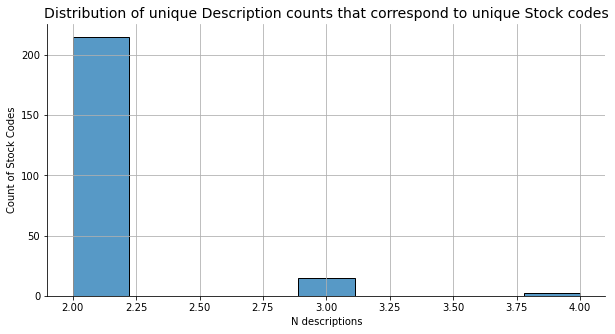

In [25]:
code_descr_counts=[]
for i in range(len(code_descr_list_to_fix)):
    code_descr_counts.append(len(code_descr_list_to_fix[i][1]))
plt.figure(figsize=(10,5))
sns.histplot(code_descr_counts) 
sns.despine()
plt.grid()
plt.title('Distribution of unique Description counts that correspond to unique Stock codes', fontsize = 14)
plt.xlabel('N descriptions')
plt.ylabel('Count of Stock Codes')
plt.show()

In [26]:
print(len(code_descr_list_to_fix),'of Stock Codes have 2 and more different Descriptions, that are normal, but contradict one another')

232 of Stock Codes have 2 and more different Descriptions, that are normal, but contradict one another


Visualyzing the remaining **Srock codes** and their **Descriptions**:

In [27]:
code_descr_list_to_fix[:40]

[['85123A',
  ['WHITE HANGING HEART T-LIGHT HOLDER',
   'CREAM HANGING HEART T-LIGHT HOLDER']],
 ['71053', ['WHITE METAL LANTERN', 'WHITE MOROCCAN METAL LANTERN']],
 ['22632', ['HAND WARMER RED POLKA DOT', 'HAND WARMER RED RETROSPOT']],
 ['22900',
  [' SET 2 TEA TOWELS I LOVE LONDON ', 'SET 2 TEA TOWELS I LOVE LONDON ']],
 ['82486',
  ['WOOD S/3 CABINET ANT WHITE FINISH',
   '3 DRAWER ANTIQUE WHITE WOOD CABINET']],
 ['84997B',
  ['RED 3 PIECE RETROSPOT CUTLERY SET', 'CHILDRENS CUTLERY RETROSPOT RED ']],
 ['84997C',
  ['BLUE 3 PIECE POLKADOT CUTLERY SET', 'CHILDRENS CUTLERY POLKADOT BLUE']],
 ['20725', ['LUNCH BAG RED RETROSPOT', 'LUNCH BAG RED SPOTTY']],
 ['21175', ['GIN + TONIC DIET METAL SIGN', 'GIN AND TONIC DIET METAL SIGN']],
 ['22778', ['GLASS CLOCHE SMALL', 'GLASS BELL JAR SMALL']],
 ['22466',
  ['FAIRY TALE COTTAGE NIGHTLIGHT', 'FAIRY TALE COTTAGE NIGHT LIGHT']],
 ['22963', ['JAM JAR WITH GREEN LID', 'JAM JAR WITH BLUE LID']],
 ['22197', ['SMALL POPCORN HOLDER', 'POPCORN HOLDER

Looks like they are more or less similar with different word order or detailes mentioned. Also, there are still some strange **Descriptions** like `AMAZON` or `FOUND`. Some differences are about color of the product, like `white` or `cream`. I think, the best option here is to take the logest **Description** variant, so it shoulb be the most detailed and we'll got rid of single-word variants. Also, I hope, that color differencies won't affect the futher analysis.

Creating a new list, that will be used for maping dictionary creation:

In [28]:
longest_descriptions = [[sublist[0], max(sublist[1], key=len)] for sublist in code_descr_list_to_fix]
fixing_dict = { k[0]: k[1] for k in longest_descriptions }

And appling it to the dataframe:

In [29]:
df.loc[df['StockCode'].isin(fixing_dict.keys()), 'Description'] = df['StockCode'].map(fixing_dict)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536087 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536087 non-null  object        
 1   StockCode    536087 non-null  object        
 2   Description  535975 non-null  object        
 3   Quantity     536087 non-null  int64         
 4   InvoiceDate  536087 non-null  datetime64[ns]
 5   UnitPrice    536087 non-null  float64       
 6   CustomerID   401136 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 48.8+ MB


And the last step is to drop the rows, that have *nans* in **Description**, as the only left such *nans* are those, where was only 1 variant of **Description** and it was *nan*

In [31]:
df = df.dropna(subset = 'Description')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535975 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535975 non-null  object        
 1   StockCode    535975 non-null  object        
 2   Description  535975 non-null  object        
 3   Quantity     535975 non-null  int64         
 4   InvoiceDate  535975 non-null  datetime64[ns]
 5   UnitPrice    535975 non-null  float64       
 6   CustomerID   401136 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 32.7+ MB


In [32]:
len(df.Description.unique())

3803

All problems with the `Description` column are fixed!

### Creating additional columns
I will add here columns with the stripped month, day of the week and hour of the day for further analysis

In [33]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%b %y')
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.strftime('%A')
df['InvoiceHourOfDay'] = df['InvoiceDate'].dt.strftime('%H')

In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceMonth,InvoiceDayOfWeek,InvoiceHourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,Nov 18,Thursday,08
1,536365,71053,WHITE MOROCCAN METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,Nov 18,Thursday,08
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,Nov 18,Thursday,08
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,Nov 18,Thursday,08
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,Nov 18,Thursday,08


All coarse data preprocessing is finished, exploratory data analysis can be carried.

# Exploratory data analysis and data cleaning
* **Creating a function for values overview**

This function will plot a scatterplot of the *values* vs *their counts*, plots another figure with trimmed 1-st and 99-th percentiles and descriptive statistics of the variable of interest:

In [35]:
def study(dataframe,variable_of_interest, zoom = True):
    # transforming initial dataframe to value counts dataframe:
    data = dataframe.value_counts()
    
    # Plotting the scatterplot with log y axis:
    plt.figure(figsize = (15,5))
    sns.scatterplot(x = data.index, y = data.values, size=data.values, sizes=(20, 200))
    plt.title(f'Distribution of {variable_of_interest} (all values)')
    plt.xlabel(variable_of_interest)
    plt.ylabel('Occurance')
    plt.grid()
    sns.despine()
    plt.yscale('log')
    plt.show()
    
    # Calculating percentiles
    perc = np.percentile(dataframe, [1,2,5,95,98,99])
    
    # Scatterplot with trimmed 1-st and 99-th percentiles
    if zoom == True:
        plt.figure(figsize = (15,5))
        sns.scatterplot(x = data.index, y = data.values, size=data.values, sizes=(20, 200))
        plt.title(f'Distribution of {variable_of_interest} (data plotted between 1-st and 99-th percentiles)', fontsize = 14)
        plt.xlabel(variable_of_interest)
        plt.ylabel('Occurance')
        plt.grid()
        plt.xlim(perc[0],perc[5])
        sns.despine()
        plt.yscale('log')
        plt.show()

    # Displaying descriptive statistics    
    display(dataframe.describe())
    print()
    perc = np.percentile(dataframe, [1,2,5,95,98,99])
    print('1% =',perc[0])
    print('2% =',perc[1])
    print('5% =',perc[2])
    print('95% =',perc[3])
    print('98% =',perc[4])
    print('99% =', perc[5])
    print()
    print((dataframe == 0).sum(), 'values equal to 0')
    print((dataframe > 0).sum(), 'positive values')
    print((dataframe < 0).sum(), 'negative values')

Also, during the EDA I will clean out detected anomalies on the go.

### Unit Price distributions

Vizualizing the distribution with dropping the **Stock Code** duplicates, so 1 item appears only 1 time on the plot. Assuming, that here can be different **Unit Prices** for the same **Stock codes** I will take the median of it's price (and I should have 1 **Description** for 1 **Stock Code**, so will use the *max* agg for them):

In [36]:
single_goods = df.groupby('StockCode').agg({'UnitPrice':'median', 'Description':'max'}).reset_index()

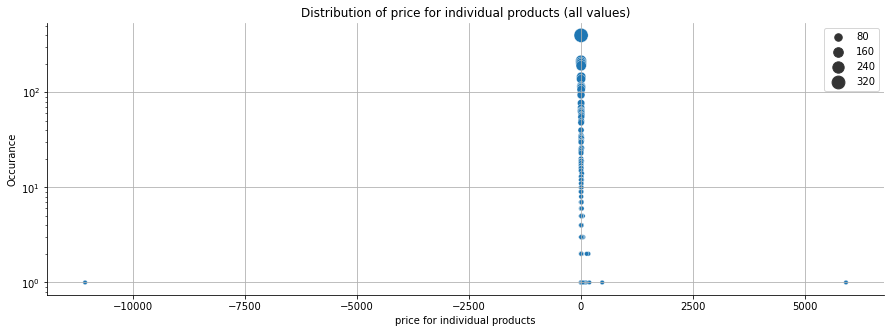

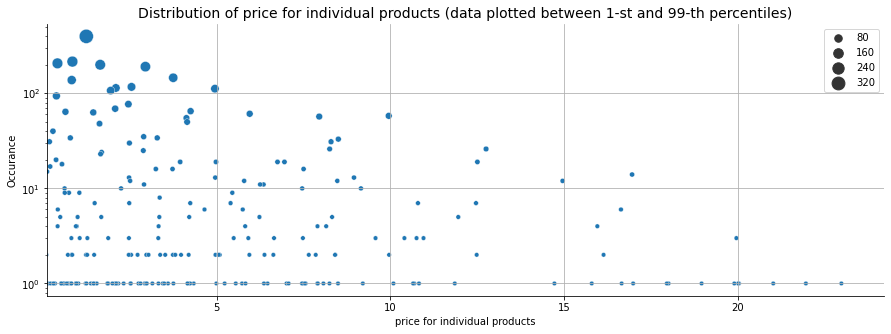

count     3939.000000
mean         2.414279
std        200.156782
min     -11062.060000
25%          0.850000
50%          2.080000
75%          4.130000
max       5909.875000
Name: UnitPrice, dtype: float64


1% = 0.12
2% = 0.19
5% = 0.39
95% = 9.95
98% = 15.95
99% = 24.197599999999785

30 values equal to 0
3908 positive values
1 negative values


In [37]:
study(single_goods.UnitPrice, 'price for individual products')

There are some goods with negative price:

In [38]:
df[df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceMonth,InvoiceDayOfWeek,InvoiceHourOfDay
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN,Aug 19,Saturday,14
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN,Aug 19,Saturday,14


Those are something `Adjust bad debt` with a strange **Stock Code**, better drop them, as they are definitely not a products. Also, there some goods with zero price:

In [39]:
len(df[df['UnitPrice']==0])

2364

And there are 2364 rows with 0 price, which is also not normal. Also, this subset contains most rows without **Customer ID**. Maybe, better to drop them. So, for further analysis, I will take only those goods with positive price. For an upper limit I will choose the rounded 99-th percentile:

In [40]:
df = df[(df['UnitPrice'] > 0) & (df['UnitPrice'] < (np.percentile(df['UnitPrice'], 99)))]

Recreating a new `single_goods` subset for visualization of the cleaned variable distribution:

In [41]:
single_goods = df.groupby('StockCode').agg({'UnitPrice':'median', 'Description':'max'}).reset_index()

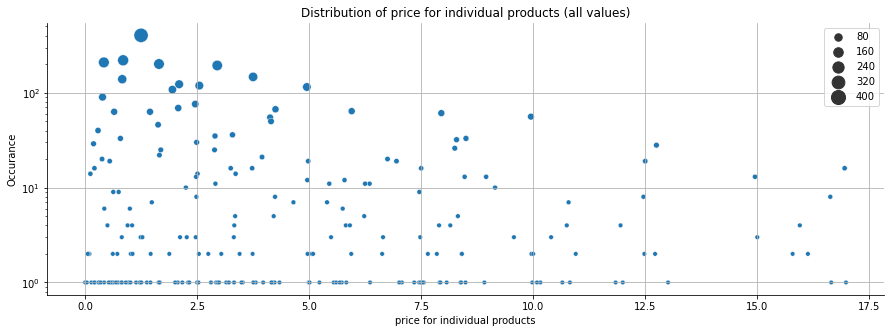

count    3886.000000
mean        3.120422
std         3.065576
min         0.001000
25%         1.161250
50%         2.100000
75%         4.130000
max        16.980000
Name: UnitPrice, dtype: float64


1% = 0.19
2% = 0.29
5% = 0.39
95% = 9.95
98% = 12.75
99% = 14.95

0 values equal to 0
3886 positive values
0 negative values


In [42]:
study(single_goods.UnitPrice, 'price for individual products', False)

The mean price is 3.1 per item, median is 2.1. 75% of more of item prices are less or equal to 4.13.

So, the obviously outlined values are cleaned up and we are good to proceed.

* **The 10 most expensive prodicts are:**

In [43]:
single_goods[['Description','UnitPrice']].sort_values(by = 'UnitPrice', ascending = False).head(10)

,Description,UnitPrice
2673,DOORMAT BLACK FLOCK,16.98
1649,CHEST OF DRAWERS GINGHAM HEART,16.95
2266,ROCOCO WALL MIRROR WHITE,16.95
3337,CREAM SWEETHEART WALL CABINET,16.95
1786,WOODEN ADVENT CALENDAR CREAM,16.95
1845,SPACEBOY BABY GIFT SET,16.95
1846,DOLLY GIRL BABY GIFT SET,16.95
1847,I LOVE LONDON BABY GIFT SET,16.95
1848,CIRCUS PARADE BABY GIFT SET,16.95
1378,SEWING BOX RETROSPOT DESIGN,16.95


* **The 10 least expensive products are:**

In [44]:
single_goods[['Description','UnitPrice']].sort_values(by = 'UnitPrice').head(10)

,Description,UnitPrice
3882,PADS TO MATCH ALL CUSHIONS,0.001
39,POPART WOODEN PENCILS ASST,0.040
64,LETTER SHAPE PENCIL SHARPENER,0.060
65,CARTOON PENCIL SHARPENERS,0.060
105,BLUE STONES ON WIRE FOR CANDLE,0.080
76,PIECE OF CAMO STATIONERY SET,0.080
91,PORCELAIN BUDAH INCENSE HOLDER,0.100
47,WRAP BAD HAIR DAY,0.100
2635,ICON PLACEMAT POP ART ELVIS,0.120
29,SMALL FOLDING SCISSOR(POINTED EDGE),0.120


**Unit Price** column is studied and fixed, we may proceed.

### Quantity
* **Absolute number of bought and returned goods**

In [45]:
print(df[df.Quantity > 0]['Quantity'].sum(), 'values were purchased, while', 
      df[df.Quantity < 0]['Quantity'].sum(), 'goods were returned. The absolute number of goods sold without return is',
      df.Quantity.sum())

5554259 values were purchased, while -274956 goods were returned. The absolute number of goods sold without return is 5279303


Examples of invoices with positive values of quantities:

In [46]:
df[df.Quantity > 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceMonth,InvoiceDayOfWeek,InvoiceHourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,Nov 18,Thursday,08
1,536365,71053,WHITE MOROCCAN METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,Nov 18,Thursday,08
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,Nov 18,Thursday,08
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,Nov 18,Thursday,08
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,Nov 18,Thursday,08


Examples of invoices with negative values of quantities:

In [47]:
df[df.Quantity < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceMonth,InvoiceDayOfWeek,InvoiceHourOfDay
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311.0,Nov 18,Thursday,09
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548.0,Nov 18,Thursday,10
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0,Nov 18,Thursday,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0,Nov 18,Thursday,10
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0,Nov 18,Thursday,10


Seems like returns should have the letter **C** in the beginning of the **InvoceNo**. This should be checked:

In [48]:
cancelled = df[df['InvoiceNo'].str.startswith('C')]
cancelled[cancelled['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceMonth,InvoiceDayOfWeek,InvoiceHourOfDay


In [49]:
non_cancelled = df[~df['InvoiceNo'].str.startswith('C')]
non_cancelled[non_cancelled['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceMonth,InvoiceDayOfWeek,InvoiceHourOfDay


Everything's fine here, no positive `Quantitly` values have **C** in the beginning of the `InvoiceNo` and all negative `Quantitly` invoices have **C** in the beginning of thier number.

* **Studying distribution of how many goods of 1 type were bought in 1 purchase:**

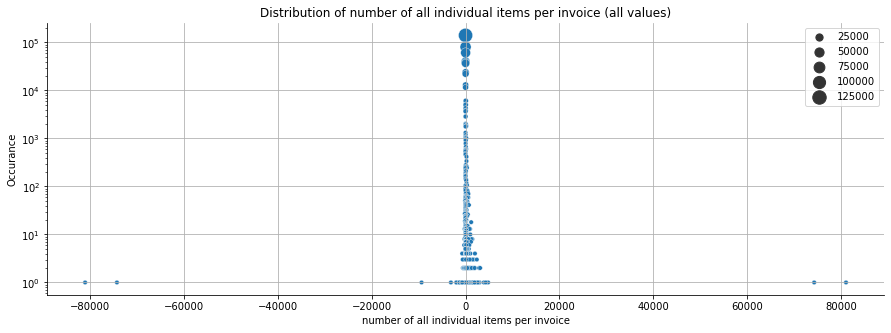

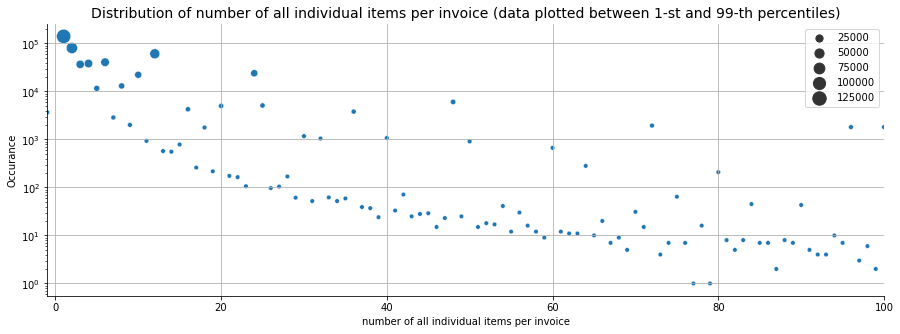

count    528107.000000
mean          9.996654
std         217.611731
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64


1% = -1.0
2% = 1.0
5% = 1.0
95% = 30.0
98% = 72.0
99% = 100.0

0 values equal to 0
519307 positive values
8800 negative values


In [50]:
study(df.Quantity, 'number of all individual items per invoice')

There are positive and negative quanities present in the dataset. The maximum and the minimum quatities are reversive here, so this is a purchase and return of the products, which may been ordered by mistake. A bit more than 1% of the quantities are negative. 99% of all values are 100 and less. For the upper threshold can be used 99-th percentile, as 100 similar items in one order seems to be a realistic number.

A bit more difficult sutiation is observed for negative values (returns). 1st percentile drops most of them and the remaining ones are mot more, than 1. In order to choose the lower threshold, which will drop the outliers, but keep realistic values, I will study negative part of the distribution separately:

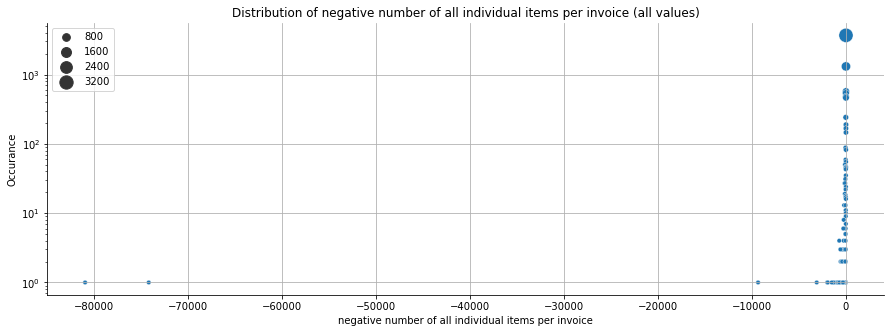

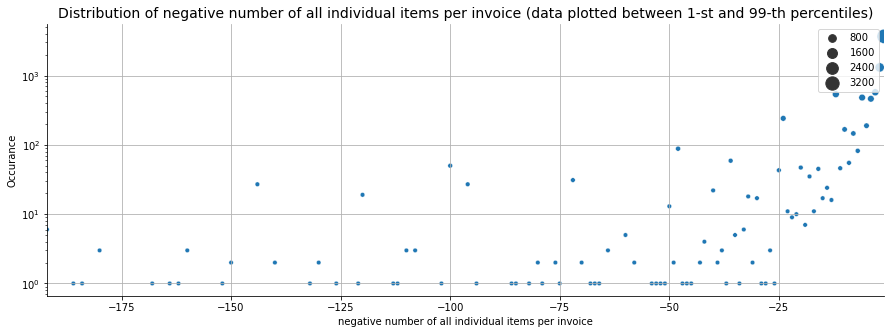

count     8800.000000
mean       -31.245000
std       1177.032151
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64


1% = -192.0
2% = -100.0
5% = -38.0
95% = -1.0
98% = -1.0
99% = -1.0

0 values equal to 0
0 positive values
8800 negative values


In [51]:
study(df[df.Quantity<0].Quantity, 'negative number of all individual items per invoice')

There are much less negative values in the dataset, so the 1st percentile of the negative values is -192, which is in absolut bigger, than the 99% of all values. It can be used as a lower threshold, but, it seems to me to better put it simmetrically to the upper threshold, so the big purchases, that are returned, will have the corresponded positive values.

Applying the thresholds:

In [52]:
df = df[abs(df.Quantity) <= 100]

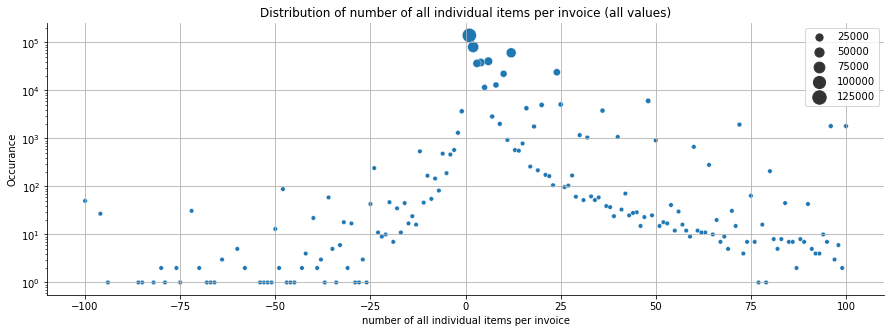

count    523100.000000
mean          7.809178
std          12.793115
min        -100.000000
25%           1.000000
50%           3.000000
75%          10.000000
max         100.000000
Name: Quantity, dtype: float64


1% = -1.0
2% = 1.0
5% = 1.0
95% = 25.0
98% = 48.0
99% = 72.0

0 values equal to 0
514465 positive values
8635 negative values


In [53]:
study(df.Quantity, 'number of all individual items per invoice', False)

Mean quantity of identical items in separate invoices is 7.8, median is 3. 75-th percentile is 10, so overwhelming majority of the invoices has 10 and less identical items.

### Metrics for Invoices
* **How many items are bought and returned in 1 invoice**

In [54]:
print(df.InvoiceNo.nunique(), 'invoices are logged in the dataframe')

22790 invoices are logged in the dataframe


In [55]:
invoices_gr = df.groupby('InvoiceNo')['Quantity'].sum().reset_index()

In [56]:
print(invoices_gr[~invoices_gr['InvoiceNo'].str.startswith('C')]['InvoiceNo'].count(), 'of ivoices are selling ones')
print(invoices_gr[invoices_gr['InvoiceNo'].str.startswith('C')]['InvoiceNo'].count(), 'of ivoices are returned ones')
print(invoices_gr[~invoices_gr['InvoiceNo'].str.startswith('C')]['InvoiceNo'].count()-
      invoices_gr[invoices_gr['InvoiceNo'].str.startswith('C')]['InvoiceNo'].count(), 
      'more invoices were sold, than returned')

19356 of ivoices are selling ones
3434 of ivoices are returned ones
15922 more invoices were sold, than returned


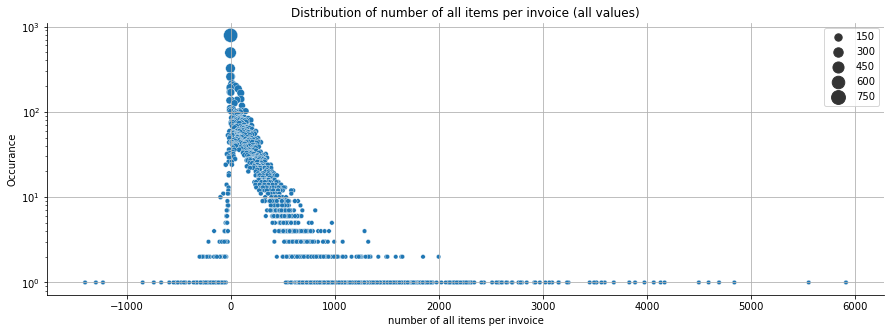

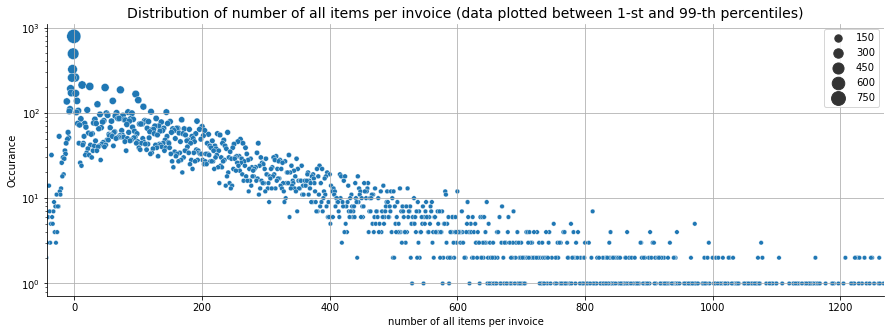

count    22790.000000
mean       179.244449
std        274.480976
min      -1400.000000
25%         28.000000
50%        110.000000
75%        235.000000
max       5913.000000
Name: Quantity, dtype: float64


1% = -43.0
2% = -21.0
5% = -7.0
95% = 574.0
98% = 883.2200000000012
99% = 1268.550000000003

0 values equal to 0
19356 positive values
3434 negative values


In [57]:
study(invoices_gr['Quantity'],'number of all items per invoice')

The observed distribution is more or less okay, but the max number of items bought in one **Invoice** is 5913, while 99-th procentile is 1268.5. Looking on the whole distribution, it may be better to trim the upper side of it a bit, for example, at the 3000. It is way bigger, than 99-th procentile, but will create a bit more homogenic overall picture.

In [58]:
df = df[df['InvoiceNo'].isin(invoices_gr[invoices_gr['Quantity']<3000]['InvoiceNo'])]
invoices_gr = df.groupby('InvoiceNo')['Quantity'].sum().reset_index()

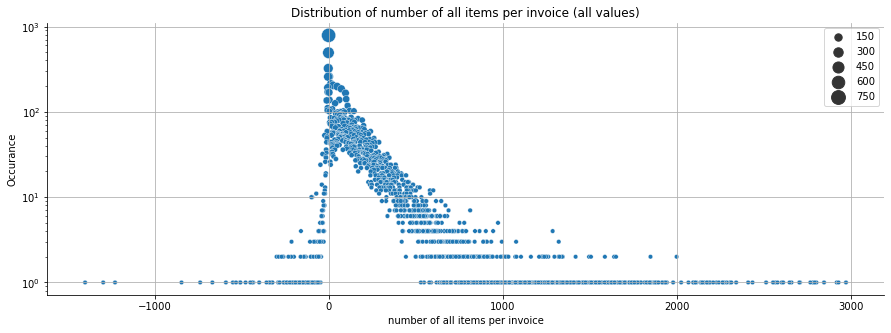

count    22764.000000
mean       175.016122
std        243.153318
min      -1400.000000
25%         28.000000
50%        110.000000
75%        234.000000
max       2971.000000
Name: Quantity, dtype: float64


1% = -43.0
2% = -21.0
5% = -7.0
95% = 569.0
98% = 857.739999999998
99% = 1222.369999999999

0 values equal to 0
19330 positive values
3434 negative values


In [59]:
study(invoices_gr['Quantity'],'number of all items per invoice', False)

Mean number of items in 1 invoice is 175, median is 110. 75% of the invoices contain 234 of less items.

Now, the data is cleaned and we may proceed.

## Popular and unpopular items

For further analysis it is best to split the dataset into 2 subsets: the items that were sold and the items, that were returned:

In [60]:
sold = df[df['Quantity']>0]
returned = df[df['Quantity']<0]

* **Top 10 products, that appeared in the biggest number of invoices:**

Here InvoiceNo stands for in how many unique invoices the item has appeared:

In [61]:
sold.groupby('Description').agg({'InvoiceNo':'nunique'}).reset_index().sort_values(by = 'InvoiceNo', ascending = False).head(10)

,Description,InvoiceNo
3574,WHITE HANGING HEART T-LIGHT HOLDER,2221
1678,JUMBO BAG RED RETROSPOT,2021
2659,REGENCY CAKESTAND 3 TIER,1725
2233,PARTY BUNTING,1662
1850,LUNCH BAG RED RETROSPOT,1546
211,ASSORTED COLOUR BIRD ORNAMENT,1398
2919,SET OF 3 CAKE TINS PANTRY DESIGN,1371
3178,SMALL POPCORN HOLDER,1341
1853,LUNCH BAG SUKI DESIGN,1269
1842,LUNCH BAG BLACK SKULL.,1263


* **10 best selling items:**

In [62]:
sold.groupby('StockCode').agg({'Quantity':'sum', 'Description':'max'}).reset_index().sort_values(by = 'Quantity', ascending = False).head(10)

,StockCode,Quantity,Description
3328,85099B,31125,JUMBO BAG RED RETROSPOT
1093,22197,27690,SMALL POPCORN HOLDER
3348,85123A,24080,WHITE HANGING HEART T-LIGHT HOLDER
3141,84879,22682,ASSORTED COLOUR BIRD ORNAMENT
2861,84077,21924,WORLD WAR 2 GLIDERS ASSTD DESIGNS
431,21212,18917,PACK OF 72 RETROSPOT CAKE CASES
1074,22178,18817,VICTORIAN GLASS HANGING T-LIGHT
171,20725,17498,LUNCH BAG RED RETROSPOT
3181,84946,16147,ANTIQUE SILVER TEA GLASS ETCHED
2627,47566,15778,PARTY BUNTING


The items, that were found in the biggest number of invoices are partly different from 10 best-sold items.

* **10 worst selling items:**

In [63]:
sold.groupby('StockCode').agg({'Quantity':'sum', 'Description':'max'}).reset_index().sort_values(by = 'Quantity').head(10)

,StockCode,Quantity,Description
3852,m,1,Manual
1046,22146,1,EASTER CRAFT IVY WREATH WITH CHICK
3388,85160a,1,WHITE BIRD GARDEN DESIGN MUG
3398,85170A,1,SET/6 IVORY BIRD T-LIGHT CANDLES
3411,85179a,1,GREEN BITTY LIGHT CHAIN
3501,90020,1,FILIGREE DIAMANTE CHAIN
3502,90021,1,LASER CUT MULTI STRAND NECKLACE
3511,90025B,1,BAROQUE BUTTERFLY EARRINGS RED
3513,90025E,1,BAROQUE BUTTERFLY EARRINGS MONTANA
827,21839,1,MUMMY MOUSE RED GINGHAM RIBBON


* **10 most returned items**

In [64]:
returned.groupby('StockCode').agg({'Quantity':'sum', 'Description':'max'}).reset_index().sort_values(by = 'Quantity').head(10)

,StockCode,Quantity,Description
1901,M,-770,Manual
702,22423,-705,REGENCY CAKESTAND 3 TIER
1781,85099B,-675,JUMBO BAG RED RETROSPOT
47,20725,-574,LUNCH BAG RED RETROSPOT
1259,23199,-403,JUMBO BAG APPLES
166,21212,-380,PACK OF 72 RETROSPOT CAKE CASES
1597,82494L,-353,WOODEN FRAME ANTIQUE WHITE
414,21931,-334,JUMBO STORAGE BAG SUKI
541,22178,-306,VICTORIAN GLASS HANGING T-LIGHT
1152,23057,-289,GEMSTONE CHANDELIER T-LIGHT HOLDER


Interestingly, the **manual** is observed in both 10 worst selling items and 10 most returned items. Also, items called **JUMBO BAG RED RETROSPOT**, **LUNCH BAG RED RETROSPOT** and **REGENCY CAKESTAND 3 TIER** appears in most bought and most returned items lists.

### Revenue generating
For this kind of study, the new column should be created in both subsets: the amount of money gained/lost by multiplying the item's price by quantity:

In [65]:
sold['revenue'] = sold.Quantity*sold.UnitPrice
returned['revenue'] = returned.Quantity*returned.UnitPrice

* **10 biggest revenue generating items**

In [66]:
sold.groupby('StockCode').agg({'revenue':'sum','Description':'max'}).reset_index().sort_values(by = 'revenue', ascending = False).head(10)

,StockCode,revenue,Description
1294,22423,124185.17,REGENCY CAKESTAND 3 TIER
2627,47566,86019.56,PARTY BUNTING
3348,85123A,67392.36,WHITE HANGING HEART T-LIGHT HOLDER
3328,85099B,63291.61,JUMBO BAG RED RETROSPOT
990,22086,44910.09,PAPER CHAIN KIT 50'S CHRISTMAS
2799,79321,43742.80,CHILLI LIGHTS
3141,84879,38978.34,ASSORTED COLOUR BIRD ORNAMENT
2110,23298,37091.54,"BUNTING , SPOTTY"
1913,23084,33567.73,RABBIT NIGHT LIGHT
171,20725,33031.34,LUNCH BAG RED RETROSPOT


* **10 smallest revenue generating items**

In [67]:
sold.groupby('StockCode').agg({'revenue':'sum','Description':'max'}).reset_index().sort_values(by = 'revenue').head(10)

,StockCode,revenue,Description
3850,PADS,0.003,PADS TO MATCH ALL CUSHIONS
2874,84227,0.420,HEN HOUSE W CHICK IN NEST
468,21268,0.840,VINTAGE BLUE TINSEL REEL
3607,90084,0.850,PINK CRYSTAL GUITAR PHONE CHARM
2867,84201C,0.950,HAPPY BIRTHDAY CARD TEDDY/CAKE
2869,84206B,0.950,CAT WITH SUNGLASSES BLANK CARD
3216,84990,1.100,60 GOLD AND SILVER FAIRY CAKE CASES
2446,35597A,1.250,DUSTY PINK CHRISTMAS TREE 30CM
2447,35597B,1.250,BLACKCHRISTMAS TREE 30CM
304,21009,1.250,ETCHED GLASS STAR TREE DECORATION


* **10 items, that caused most money returns**

In [68]:
returned.groupby('StockCode').agg({'revenue':'sum','Description':'max'}).reset_index().sort_values(by = 'revenue').head(10)

,StockCode,revenue,Description
702,22423,-8054.55,REGENCY CAKESTAND 3 TIER
369,21843,-1952.50,RED RETROSPOT CAKE STAND
985,22838,-1671.60,3 TIER CAKE TIN RED AND CREAM
1901,M,-1440.76,Manual
1594,82483,-1225.85,WOOD 2 DRAWER CABINET WHITE FINISH
1781,85099B,-1211.42,JUMBO BAG RED RETROSPOT
1521,47566,-1201.35,PARTY BUNTING
1076,22960,-1012.79,JAM MAKING SET WITH JARS
936,22752,-952.00,SET 7 BABUSHKA NESTING BOXES
1597,82494L,-910.95,WOODEN FRAME ANTIQUE WHITE


Here we can see, that item called **JUMBO BAG RED RETROSPOT** appeared in both 10-biggest revenue generated and 10-most money returned subsets. This may mean that this popular product also may have a big amount of manufacturing defects, as return rate is really high.

### Return rates of the items

Preparing the subset:

In [69]:
return_rates = returned.groupby('Description').agg({'Quantity':'sum'}).reset_index()
return_rates2 = sold[sold['Description'].isin(return_rates['Description'])].groupby('Description').agg({'Quantity':'sum'}).reset_index()
return_rates = return_rates.merge(return_rates2, how = 'inner', on = 'Description', suffixes=('_returned', '_sold'))
return_rates['return_rate'] = abs(return_rates['Quantity_returned'])/return_rates['Quantity_sold']
return_rates['return_rate'].describe()

count    1883.000000
mean        0.048651
std         0.205354
min         0.000183
25%         0.006385
50%         0.015314
75%         0.034188
max         7.000000
Name: return_rate, dtype: float64

Mean return rate is 0.05 and median is 0.015. Maximum is 7, so there are some products, which were return 7-fold times more, that bought! This is definitely a mistake here or the returns were logged on products, that were bought before the time period of the dataset.

In [70]:
return_rates[return_rates['return_rate'] >= 1]

,Description,Quantity_returned,Quantity_sold,return_rate
39,3 WICK CHRISTMAS BRIAR CANDLE,-4,3,1.333333
162,BLACK CHERRY LIGHTS,-8,8,1.000000
203,BLUE PADDED SOFT MOBILE,-7,1,7.000000
290,CARRIAGE,-1,1,1.000000
692,GLASS CAKE COVER AND PLATE,-2,2,1.000000
761,HANGING RIDGE GLASS T-LIGHT HOLDER,-36,36,1.000000
1182,PINK CHERRY LIGHTS,-8,4,2.000000
1214,PINK POODLE HANGING DECORATION,-12,5,2.400000
1217,PINK SMALL GLASS CAKE STAND,-27,24,1.125000
1386,ROBIN CHRISTMAS CARD,-12,10,1.200000


These items may need special attention and data, that is not presented in the dataset. For the analysis I will drop them:

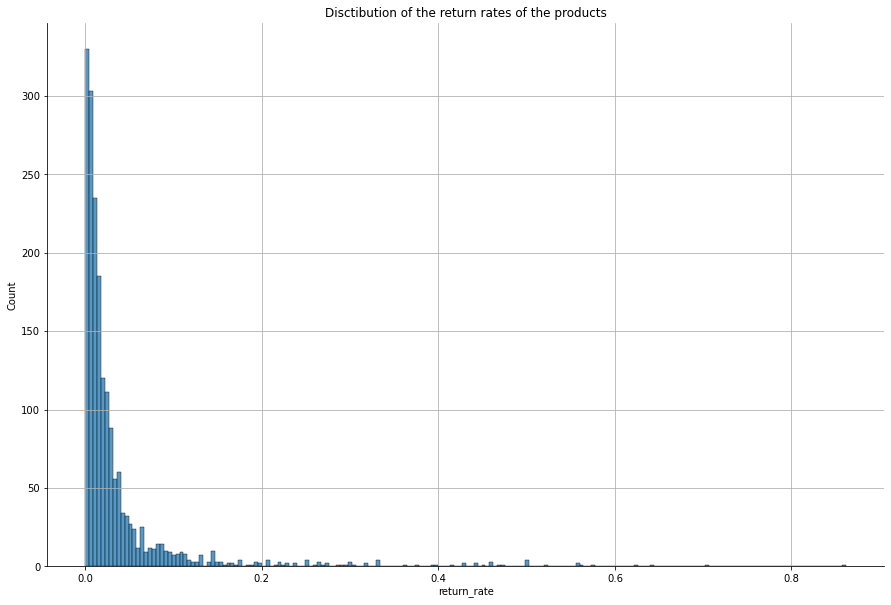

count    1871.000000
mean        0.037387
std         0.074585
min         0.000183
25%         0.006344
50%         0.015088
75%         0.033800
max         0.862069
Name: return_rate, dtype: float64

In [71]:
return_rates = return_rates[~(return_rates['return_rate'] >= 1)]
plt.figure(figsize = (15,10))
sns.histplot(data = return_rates, x = 'return_rate')
sns.despine()
plt.title('Disctibution of the return rates of the products')
plt.grid()
plt.show()
return_rates['return_rate'].describe()

Most of the products have return rate from 0 to 0.05 with mean of 0.037 and median 0.015. 75-th percentile contain return rates less and equal to 0.034. This distribution seems okay for the online store.

* **10 products with the highest return rates:**

In [72]:
return_rates[['Description','return_rate']].sort_values(by = 'return_rate', ascending = False).head(10)

,Description,return_rate
1200,PINK HEARTS PAPER GARLAND,0.862069
713,GOLDIE LOOKING MIRROR,0.705882
163,BLACK DIAMANTE EXPANDABLE RING,0.640000
220,BLUE TILED TRAY,0.625000
605,FLOWERS CHANDELIER T-LIGHT HOLDER,0.575221
828,IVORY CHANDELIER T-LIGHT HOLDER,0.561404
181,BLUE VOILE LAMPSHADE,0.558140
1221,PINK/BLUE DISC/MIRROR STRING,0.558140
1194,PINK FOXGLOVE ARTIIFCIAL FLOWER,0.521739
1047,Manual,0.501956


This products should have special attention from the store managers, as they all have return rate more than 0.5. I think, it is a good idea to drop them from the assortiment.

### Discovering invoices distributions by time
* **Throughout the year**

Creating a subsets with only unique **InvoceNo**:

In [73]:
sold_inv_unique = sold.drop_duplicates('InvoiceNo')[['InvoiceNo','InvoiceDate','InvoiceMonth','InvoiceDayOfWeek','InvoiceHourOfDay']]
returned_inv_unique = returned.drop_duplicates('InvoiceNo')[['InvoiceNo','InvoiceDate','InvoiceMonth','InvoiceDayOfWeek','InvoiceHourOfDay']]

Counting sold and returned invoices: 

In [74]:
sold_month = sold_inv_unique.groupby('InvoiceMonth').agg({'InvoiceNo':'nunique','InvoiceDate':'max'}).sort_values(by = 'InvoiceDate').reset_index()
returned_month = returned_inv_unique.groupby('InvoiceMonth').agg({'InvoiceNo':'nunique','InvoiceDate':'max'}).sort_values(by = 'InvoiceDate').reset_index()
returned_month['InvoiceNo'] = returned_month['InvoiceNo']*(-1)

Plotting the data:

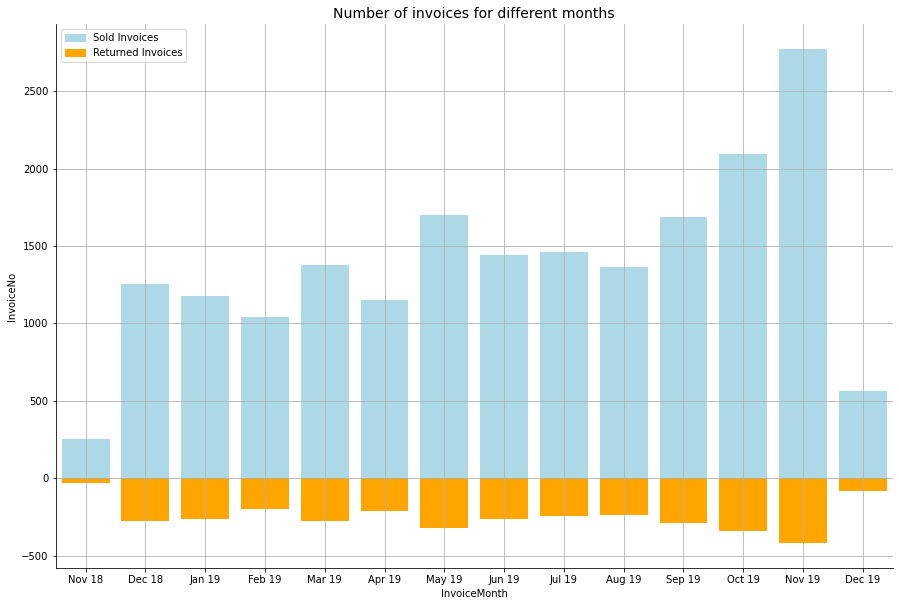

In [75]:
plt.figure(figsize = (15,10))
sns.barplot(data = sold_month, x = 'InvoiceMonth', y = 'InvoiceNo',facecolor='lightblue')
sns.barplot(data = returned_month, x = 'InvoiceMonth', y = 'InvoiceNo',facecolor='orange')
sns.despine()
sell = mpatches.Patch(color='lightblue', label='Sold Invoices')
ret = mpatches.Patch(color='orange', label='Returned Invoices')
plt.legend(handles=[sell,ret])
plt.title('Number of invoices for different months', fontsize = 14)
plt.grid()

### Conclusion

2 peaks are observable: in May and in November 19. Also, there is a well-defined rise from September to November.

This distribution also has a simmetrical peaks in items return in May and November.

* **Throughout the week:**

The same pipeline as for year-distribution:

In [76]:
sold_week = sold_inv_unique.groupby(sold_inv_unique['InvoiceDate'].dt.date).agg({'InvoiceNo':'nunique','InvoiceDayOfWeek':'max'}).reset_index()
returned_week = returned_inv_unique.groupby(returned_inv_unique['InvoiceDate'].dt.strftime('%Y-%m-%d')).agg({'InvoiceNo':'nunique','InvoiceDayOfWeek':'max'}).sort_values(by = 'InvoiceDate').reset_index()
returned_week['InvoiceNo'] = returned_week['InvoiceNo']*(-1)

In [77]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday']

sold_week['InvoiceDayOfWeek'] = pd.Categorical(sold_week['InvoiceDayOfWeek'], categories=weekday_order, ordered=True)
returned_week['InvoiceDayOfWeek'] = pd.Categorical(returned_week['InvoiceDayOfWeek'], categories=weekday_order, ordered=True)

sold_week = sold_week.sort_values('InvoiceDayOfWeek')
returned_week = returned_week.sort_values('InvoiceDayOfWeek')

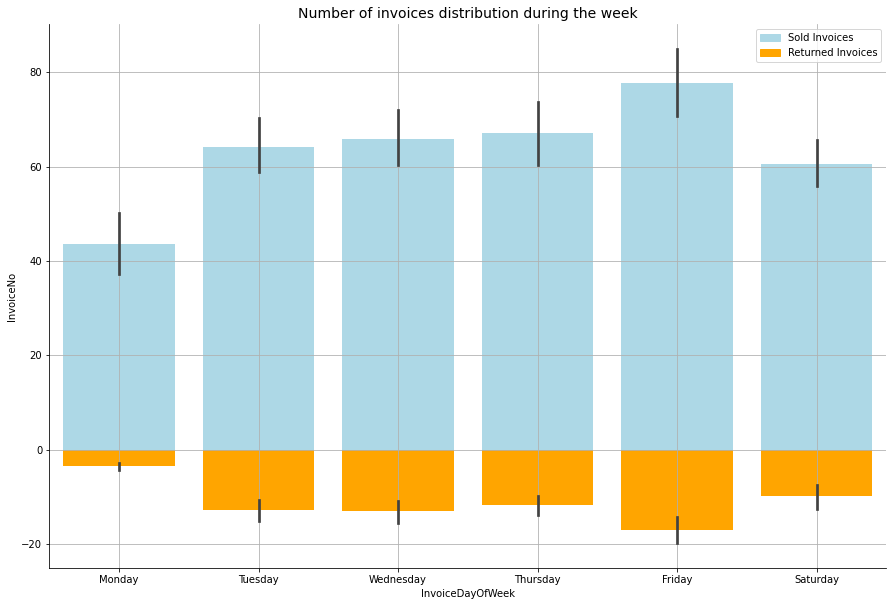

In [78]:
plt.figure(figsize = (15,10))
sns.barplot(data = sold_week, x = 'InvoiceDayOfWeek', y = 'InvoiceNo',facecolor='lightblue')
sns.barplot(data = returned_week, x = 'InvoiceDayOfWeek', y = 'InvoiceNo',facecolor='orange')
sns.despine()
sell = mpatches.Patch(color='lightblue', label='Sold Invoices')
ret = mpatches.Patch(color='orange', label='Returned Invoices')
plt.legend(handles=[sell,ret])
plt.title('Number of invoices distribution during the week', fontsize = 14)
plt.grid()

### Conclusion

The most active day for ordering is Friday, and the least one is Monday. The same is for returns. Interestingly, this pattern is consistent across the whole observed period, as the observed errorbars are quite small.

* **Throughout the day**

The same pipeline as for previous 2 analyzes:

In [79]:
sold_by_hours = sold_inv_unique.groupby([sold_inv_unique['InvoiceDate'].dt.date, 'InvoiceHourOfDay']).agg({'InvoiceNo':'nunique'}).reset_index().sort_values(by='InvoiceHourOfDay')
returned_by_hours = returned_inv_unique.groupby([returned_inv_unique['InvoiceDate'].dt.date, 'InvoiceHourOfDay']).agg({'InvoiceNo':'nunique'}).reset_index().sort_values(by='InvoiceHourOfDay')
returned_by_hours['InvoiceNo'] = returned_by_hours['InvoiceNo']*(-1)

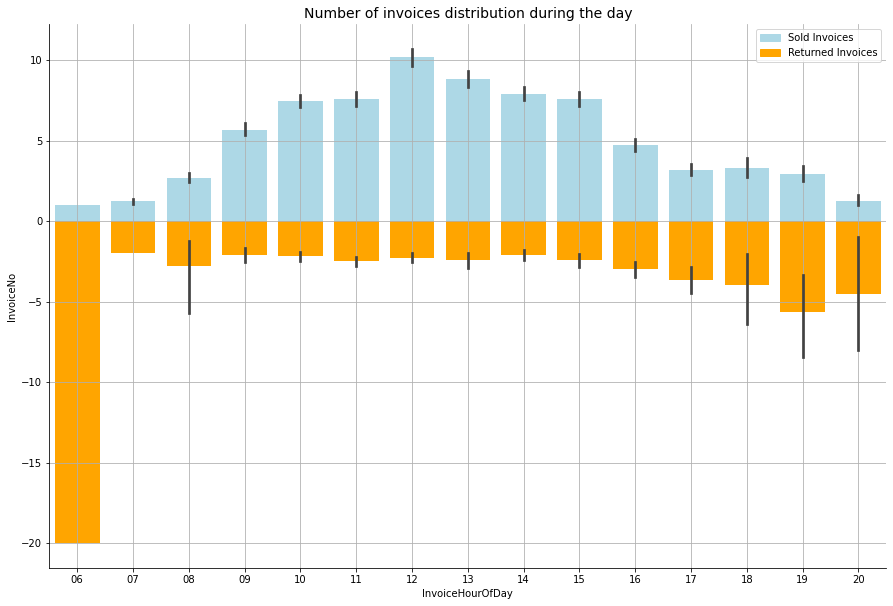

In [80]:
plt.figure(figsize = (15,10))
sns.barplot(data = sold_by_hours, x = 'InvoiceHourOfDay', y = 'InvoiceNo',facecolor='lightblue')
sns.barplot(data = returned_by_hours, x = 'InvoiceHourOfDay', y = 'InvoiceNo',facecolor='orange')
sns.despine()
sell = mpatches.Patch(color='lightblue', label='Sold Invoices')
ret = mpatches.Patch(color='orange', label='Returned Invoices')
plt.legend(handles=[sell,ret])
plt.title('Number of invoices distribution during the day', fontsize = 14)
plt.grid()

There is a big outlying peak of returns at 6:00 in the morning. Also, the abscence of errorbar tells, that there is only single order and single return has been done at this time, so it can be dropped for more beautiful visualization:

In [81]:
sold_by_hours[sold_by_hours['InvoiceHourOfDay'] == '06']

,InvoiceDate,InvoiceHourOfDay,InvoiceNo
1954,2019-08-16,06,1


In [82]:
returned_by_hours[returned_by_hours['InvoiceHourOfDay'] == '06']

,InvoiceDate,InvoiceHourOfDay,InvoiceNo
907,2019-08-16,06,-20


In [83]:
sold_by_hours = sold_by_hours[sold_by_hours['InvoiceHourOfDay'] != '06']
returned_by_hours = returned_by_hours[returned_by_hours['InvoiceHourOfDay'] != '06']

Revisualization:

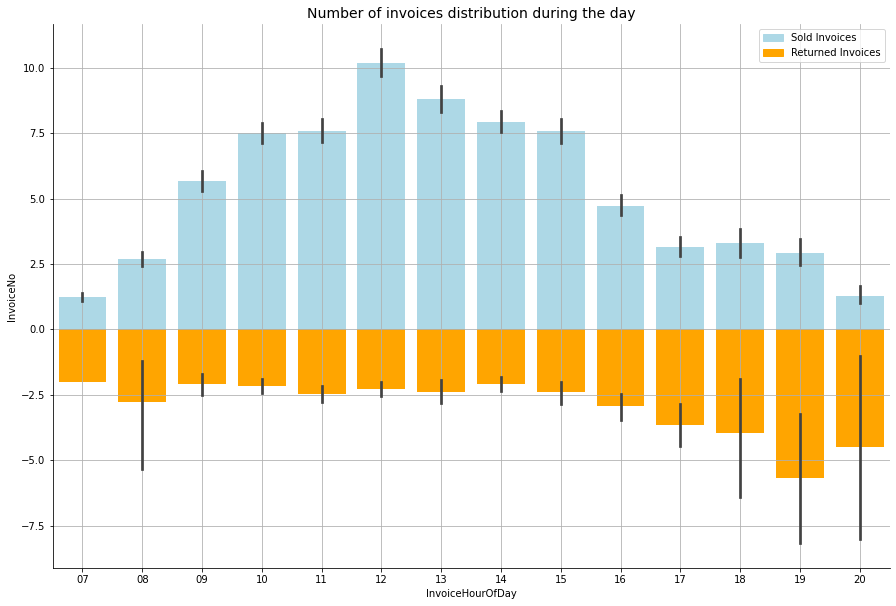

In [84]:
plt.figure(figsize = (15,10))
sns.barplot(data = sold_by_hours, x = 'InvoiceHourOfDay', y = 'InvoiceNo',facecolor='lightblue')
sns.barplot(data = returned_by_hours, x = 'InvoiceHourOfDay', y = 'InvoiceNo',facecolor='orange')
sns.despine()
sell = mpatches.Patch(color='lightblue', label='Sold Invoices')
ret = mpatches.Patch(color='orange', label='Returned Invoices')
plt.legend(handles=[sell,ret])
plt.title('Number of invoices distribution during the day', fontsize = 14)
plt.grid()

### Conclusion

The most active hour for ordering is 12:00. Biggest amount of of orders has been done from 10:00 till 15:00. This dynamics are consistent across the whole observed time period, as errorbars are very small.

The most active hours for returns are from 17:00 till 20:00. Also, the errorbars there are quite big, saying, that this activity peaks are not very consistent across the studied period.

### Discovering revenue accumulation during the year

In [85]:
df['revenue'] = df['UnitPrice']*df['Quantity']

In [86]:
for_lineplot = df.groupby('InvoiceMonth').agg({'revenue':'sum','InvoiceDate':'min'}).sort_values(by = 'InvoiceDate')

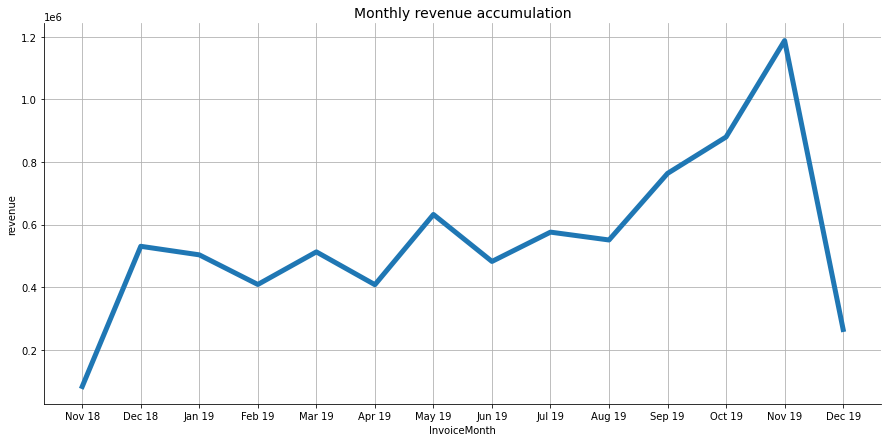

In [87]:
plt.figure(figsize = (15,7))
sns.lineplot(data = for_lineplot, x = 'InvoiceMonth', y = 'revenue',linewidth=5)
sns.despine()
plt.grid()
plt.title('Monthly revenue accumulation', fontsize = 14)
plt.show()

### Conclusion

The revenue generating pattern reproduces the pattern of orders distribution across the year, which is quite logical. The biggest revenue was generated by the end of the 2019 year: stable rise from August to November. And also there is an observable peak in May.

## Which products are often bought together?
This question will be solved by **Apriory method**.

Preparing the dataset:

In [88]:
# Filtering out invoices with only 1 item ordered:
items_per_invoce = sold.groupby('InvoiceNo').agg({'Description':'nunique'})
invoices_non_single_items = items_per_invoce[items_per_invoce['Description']!=1].reset_index()['InvoiceNo']

for_apriory = sold[sold['InvoiceNo'].isin(invoices_non_single_items)]
for_apriory = for_apriory[['InvoiceNo','Description']]
for_apriory = for_apriory.reset_index().drop('index', axis = 1)

# Creating the matrix with one-hot encoded items (Boolean):
indexer_list = for_apriory['InvoiceNo'].unique()
item_list = for_apriory['Description'].unique()

one_hot_matrix = pd.DataFrame(False, index=indexer_list, columns=item_list)

for i in range(len(for_apriory)):
    one_hot_matrix.loc[str(for_apriory['InvoiceNo'][i])][for_apriory['Description'][i]] = True

Building the model:

In [89]:
frequent_itemsets = apriori(one_hot_matrix, min_support=0.02, use_colnames=True)

rules = association_rules(frequent_itemsets, metric ="lift", min_threshold = 1)

Now we can analyze product bundles from different angles:

* **Which items most often bought with the most popular items**:

In [90]:
rules.sort_values(by = ['antecedent support','support'], ascending = [False,False]).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.123308,0.040285,0.026801,0.217352,5.395320,0.021834,1.226241,0.929236
9,(WHITE HANGING HEART T-LIGHT HOLDER),(JUMBO BAG RED RETROSPOT),0.123308,0.111941,0.024517,0.198825,1.776165,0.010714,1.108446,0.498452
5,(WHITE HANGING HEART T-LIGHT HOLDER),(NATURAL SLATE HEART CHALKBOARD ),0.123308,0.069204,0.023124,0.187528,2.709798,0.014590,1.145635,0.719715
1,(WHITE HANGING HEART T-LIGHT HOLDER),(WOODEN PICTURE FRAME WHITE FINISH),0.123308,0.060846,0.022678,0.183913,3.022611,0.015175,1.150802,0.763278
7,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART OF WICKER SMALL),0.123308,0.065582,0.021452,0.173972,2.652740,0.013365,1.131218,0.710661
11,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.123308,0.091937,0.021452,0.173972,1.892288,0.010115,1.099312,0.537862
37,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.111941,0.065972,0.044297,0.395719,5.998289,0.036912,1.545685,0.938322
87,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.111941,0.065526,0.039784,0.355401,5.423789,0.032449,1.449697,0.918438
102,(JUMBO BAG RED RETROSPOT),(JUMBO SHOPPER VINTAGE RED PAISLEY),0.111941,0.064913,0.037444,0.334495,5.152942,0.030177,1.405078,0.907525
47,(JUMBO BAG RED RETROSPOT),(JUMBO BAG BAROQUE BLACK WHITE),0.111941,0.050816,0.031704,0.283225,5.573517,0.026016,1.324243,0.924015


The most populat product - **WHITE HANGING HEART T-LIGHT HOLDER** most often bought with other **Home decor** items: other tlight holders, chalkboards, pictures and etc. Aslo, some bags are observed with it.

* **Most frequent product bundles:**

In [91]:
rules.sort_values(by = ['support','confidence'], ascending = [False,False]).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
36,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.065972,0.111941,0.044297,0.671453,5.998289,0.036912,2.702988,0.892142
37,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.111941,0.065972,0.044297,0.395719,5.998289,0.036912,1.545685,0.938322
195,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.055887,0.058227,0.042291,0.756730,12.996201,0.039037,3.871305,0.977695
194,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.058227,0.055887,0.042291,0.726316,12.996201,0.039037,3.449644,0.980124
86,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.065526,0.111941,0.039784,0.607143,5.423789,0.032449,2.260515,0.872820
87,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.111941,0.065526,0.039784,0.355401,5.423789,0.032449,1.449697,0.918438
103,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.064913,0.111941,0.037444,0.576824,5.152942,0.030177,2.098558,0.861884
102,(JUMBO BAG RED RETROSPOT),(JUMBO SHOPPER VINTAGE RED PAISLEY),0.111941,0.064913,0.037444,0.334495,5.152942,0.030177,1.405078,0.907525
67,(LUNCH BAG SUKI DESIGN ),(LUNCH BAG RED RETROSPOT),0.070652,0.086087,0.035716,0.505521,5.872218,0.029634,1.848233,0.892784
66,(LUNCH BAG RED RETROSPOT),(LUNCH BAG SUKI DESIGN ),0.086087,0.070652,0.035716,0.414887,5.872218,0.029634,1.588321,0.907861


The most frequent bundles of products are the same product types: bags are bought with other bags, sets of teacups and sausers boght with other sets of teacups and sausers

* **The product bundles with the biggest lift:**

In [92]:
rules.sort_values(by = ['lift'], ascending = [False]).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
189,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.027916,0.029420,0.021173,0.758483,25.781241,0.020352,4.018683,0.988815
188,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.029420,0.027916,0.021173,0.719697,25.781241,0.020352,3.467977,0.990348
260,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.041901,0.042291,0.029810,0.711436,16.822325,0.028038,3.318880,0.981689
257,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.042291,0.041901,0.029810,0.704875,16.822325,0.028038,3.246415,0.982089
261,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.055887,0.032875,0.029810,0.533400,16.225299,0.027973,2.072707,0.993915
256,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.032875,0.055887,0.029810,0.906780,16.225299,0.027973,10.127760,0.970265
198,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.041901,0.055887,0.034880,0.832447,14.895237,0.032539,5.634707,0.973662
199,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.055887,0.041901,0.034880,0.624128,14.895237,0.032539,2.549000,0.988085
259,(ROSES REGENCY TEACUP AND SAUCER ),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.058227,0.034880,0.029810,0.511962,14.677599,0.027779,1.977549,0.989484
258,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.034880,0.058227,0.029810,0.854633,14.677599,0.027779,6.478570,0.965548



### Conclusion

The identical items in different colors and products from the same sphere are often sold together. This means, that they can be advertised on one another's pages or can be sold in bundles on the site. 

## Product categories by RFM

For this analysis the new subset has to be created. It should contain info on recency, frequency and monetary:

In [93]:
# Revealing the last registered date in the dataset:
end_date=sold.InvoiceDate.max()

# Grouping items data aggregation:
rfm=sold.groupby('Description').agg({'InvoiceDate': lambda x: (end_date-x.max()).days,
                                    'InvoiceNo': 'nunique',
                                    'revenue':'sum'}).reset_index()
#Renaming the columns:
rfm.rename(columns={'InvoiceDate':'recency',
                    'InvoiceNo':'frequency',
                   'revenue':'monetary'},inplace=True)
rfm.head()

,Description,recency,frequency,monetary
0,4 PURPLE FLOCK DINNER CANDLES,1,38,285.70
1,50'S CHRISTMAS GIFT BAG LARGE,0,130,1957.63
2,DOLLY GIRL BEAKER,0,166,1348.16
3,I LOVE LONDON MINI BACKPACK,0,86,1619.88
4,NINE DRAWER OFFICE TIDY,1,30,777.90


Visualization of the calculated distributions:

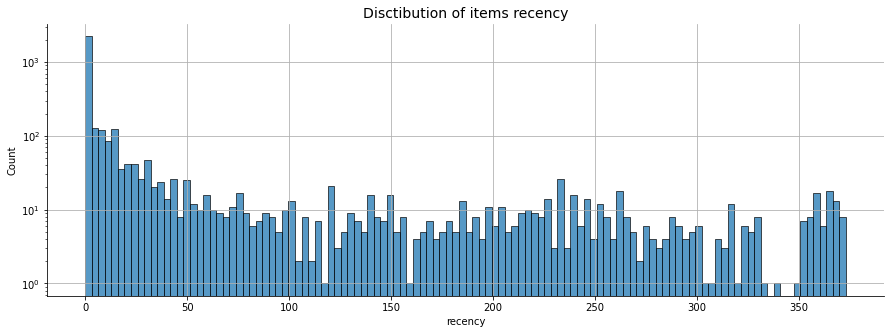

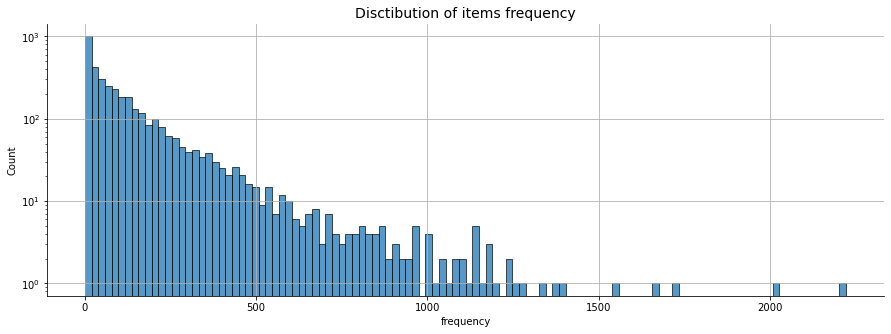

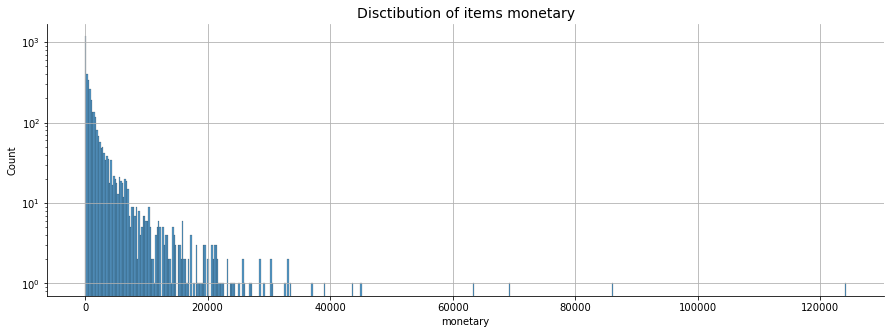

In [94]:
for i in ['recency','frequency','monetary']:
    plt.figure(figsize = (15,5))
    sns.histplot(data = rfm, x = i)
    plt.yscale('log')
    plt.grid()
    plt.title(f'Disctibution of items {i}', fontsize = 14)
    sns.despine()
    plt.show()

In order to find the optimal number of clusetrs for each metric, I will create an automated pipeline, which will calculate the silhouette score for dividing the goods by the KMeans-algorythm into number of clusters from 2 to 6 and prining the best option:

In [95]:
def cluster_solution(parameter):
    score={}
    for n_cluster in [2,3,4,5,6]:
        kmeans = KMeans(n_clusters=n_cluster).fit(
            rfm[[parameter]])
    
        silhouette_avg = silhouette_score(
            rfm[[parameter]], 
            kmeans.labels_)
        score[n_cluster]=silhouette_avg
    needed_number=max(score,key=score.get)
    return needed_number

In [96]:
#iterating over the columns and getting back the optimal number of clusters
for i in rfm[['recency','frequency','monetary']].columns:
    print(i, cluster_solution(i))

recency 2
frequency 2
monetary 2


All metrics have the best silhouette score, if the goods are divided into 2 clusters. Applying the clusterization algorythm

In [97]:
for metric in ['recency','frequency','monetary']:
    km = KMeans(n_clusters = 2, random_state=42)
    labels = km.fit_predict(rfm[[metric]])
    rfm[f'{metric}_cluster'] = labels

For easy access I will make a new column `RFM_segment`, which is a string comprehansion of values of recency, frequency and monetary:

In [98]:
rfm['RFM_segment']=rfm['recency_cluster'].astype(str)+rfm['frequency_cluster'].astype(str)+rfm['monetary_cluster'].astype(str)
rfm.head()

,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
0,4 PURPLE FLOCK DINNER CANDLES,1,38,285.70,1,0,0,100
1,50'S CHRISTMAS GIFT BAG LARGE,0,130,1957.63,1,0,0,100
2,DOLLY GIRL BEAKER,0,166,1348.16,1,0,0,100
3,I LOVE LONDON MINI BACKPACK,0,86,1619.88,1,0,0,100
4,NINE DRAWER OFFICE TIDY,1,30,777.90,1,0,0,100


Revealing the values, that are found in created clusters:

In [99]:
for metric in ['recency_cluster','frequency_cluster','monetary_cluster']:
    print(metric)
    display(rfm[rfm[metric]==0].head(1))
    display(rfm[rfm[metric]==1].head(1))

recency_cluster


,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
25,12 PINK HEN+CHICKS IN BASKET,232,14,104.55,0,0,0,000


,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
0,4 PURPLE FLOCK DINNER CANDLES,1,38,285.7,1,0,0,100


frequency_cluster


,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
0,4 PURPLE FLOCK DINNER CANDLES,1,38,285.7,1,0,0,100


,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
7,SET 2 TEA TOWELS I LOVE LONDON,0,525,11548.95,1,1,1,111


monetary_cluster


,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
0,4 PURPLE FLOCK DINNER CANDLES,1,38,285.7,1,0,0,100


,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment
7,SET 2 TEA TOWELS I LOVE LONDON,0,525,11548.95,1,1,1,111


* Recency:
 * Good: Recent 1
 * Bad: Inactive 0

* Frequency:
 * Good: Regular 1
 * Bad: Infrequent 0

* Monetary:
 * Good: Profitable 1
 * Bad: Non-profitable 0


**So, the product categories are:**
* 111: Best Products
* 110: High Potential Low Value Products
* 101: Recent High Value Performers
* 100: Inactive Low Value Products
* 011: Regular Good Performers
* 010: Regular Low Value Products
* 001: Inactive High Value Performers
* 000: Least Attractive Products

Visualization of the metrics distributions of the clusters:

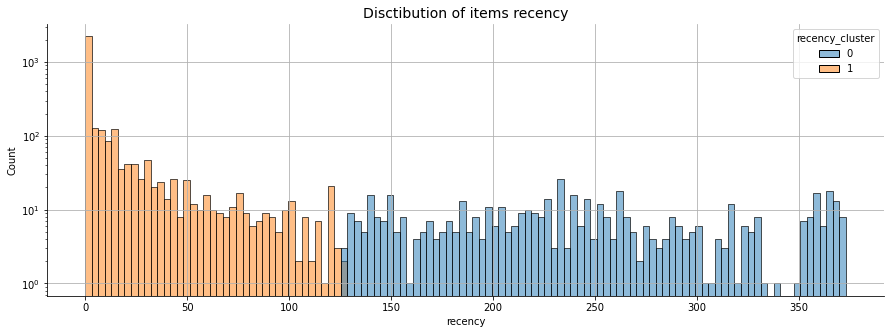

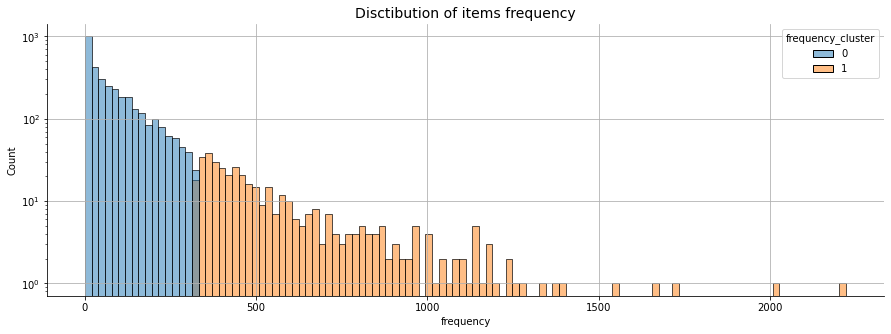

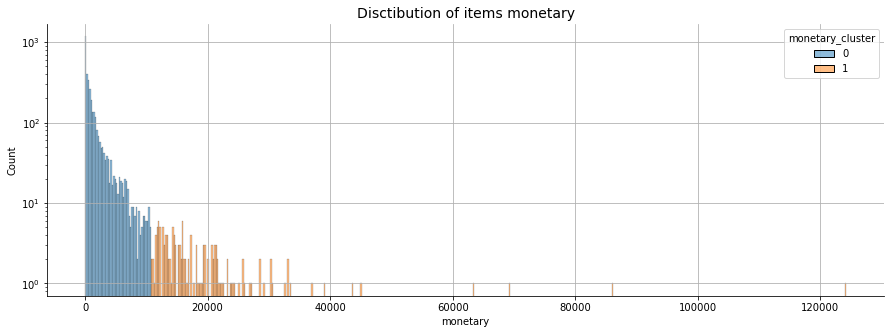

In [100]:
for i in range(3):
    plt.figure(figsize = (15,5))
    sns.histplot(data = rfm, x = ['recency','frequency','monetary'][i], 
                 hue = ['recency_cluster','frequency_cluster','monetary_cluster'][i])
    plt.yscale('log')
    plt.grid()
    title = ['recency','frequency','monetary'][i]
    plt.title(f'Disctibution of items {title}', fontsize = 14)
    sns.despine()
    plt.show()

Giving the meaningful names for the identified RFM clusters:

In [101]:
def categor(row):
    if row == '111':
        return 'Best Products'
    elif row == '110':
        return 'High Potential Low Value Products'
    elif row == '101':
        return 'Recent High Value Performers'
    elif row == '100':
        return 'Inactive Low Value Products'
    elif row == '011':
        return 'Regular Good Performers'
    elif row == '010':
        return 'Regular Low Value Products'
    elif row == '001':
        return 'Inactive High Value Performers'
    elif row == '000':
        return 'Least Attractive Products'

In [102]:
rfm['RFM_category'] = rfm['RFM_segment'].apply(categor)
rfm.head()

,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment,RFM_category
0,4 PURPLE FLOCK DINNER CANDLES,1,38,285.70,1,0,0,100,Inactive Low Value Products
1,50'S CHRISTMAS GIFT BAG LARGE,0,130,1957.63,1,0,0,100,Inactive Low Value Products
2,DOLLY GIRL BEAKER,0,166,1348.16,1,0,0,100,Inactive Low Value Products
3,I LOVE LONDON MINI BACKPACK,0,86,1619.88,1,0,0,100,Inactive Low Value Products
4,NINE DRAWER OFFICE TIDY,1,30,777.90,1,0,0,100,Inactive Low Value Products


Now the goods can be studied by the RFM-categories:
* **Number of items of each categoryin the online store:**

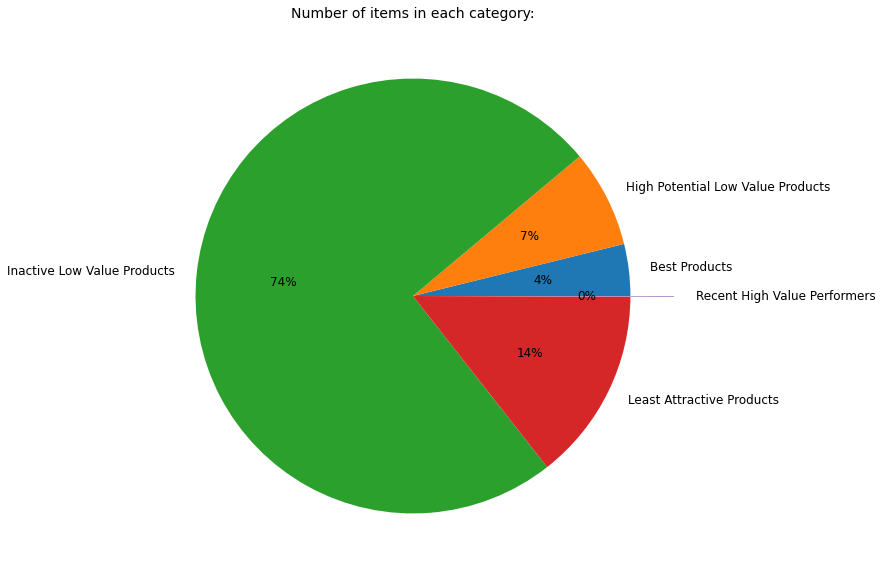

,RFM_category
Inactive Low Value Products,2786
Least Attractive Products,537
High Potential Low Value Products,271
Best Products,144
Recent High Value Performers,2


In [103]:
plt.figure(figsize = (15,10))
explode = [0, 0, 0, 0, .2]
plt.pie(rfm['RFM_category'].value_counts().sort_index().values, labels = rfm['RFM_category'].value_counts().sort_index().index, textprops={'fontsize':12}, explode=explode, autopct='%.0f%%')
plt.title('Number of items in each category:', fontsize = 14)
plt.show()

display(rfm['RFM_category'].value_counts().to_frame())

* 74% of all items, presented in the store, are `Inactive Low Value Products` - they have both low frequency and monetary. This products should be advertised more actively.
* 14% of all items are `Least Attractive Products` - these ones can be withdrawn from sale with no bad consiquances.
* 7% of items are `High Potential Low Value Products` - they are well-sold, but generate relatively small revenue. So, their prices may be higher.
* Only 4% of all items are `Best Products`
* Also, there is nearly 0% of `Recent High Value Performers` - being sold reraly, but generated high revenue. Lets see, what are they:

In [104]:
rfm[rfm['RFM_category'] == 'Recent High Value Performers']

,Description,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,RFM_segment,RFM_category
29,15CM CHRISTMAS GLASS BALL 20 LIGHTS,0,261,10910.61,1,0,1,101,Recent High Value Performers
520,BOX OF VINTAGE ALPHABET BLOCKS,0,232,11804.20,1,0,1,101,Recent High Value Performers


There are only 2 such items. They were bought relatively infrequently, but generated good monetary. Maybe, the store needs more of such products or, again, they should be advertised more.

* **Сontribution of items from different RFM-categories to sales and revenue generation**

In order to study the items from the revealed categories in more detailed way, I will add these category tags to the `sold` subset:

In [105]:
dict_for_dataframe = dict(zip(rfm['Description'], rfm['RFM_category']))
sold['RFM_category'] = sold['Description'].map(dict_for_dataframe)

And visualize their impact in revenue generation and quantities of items sold:

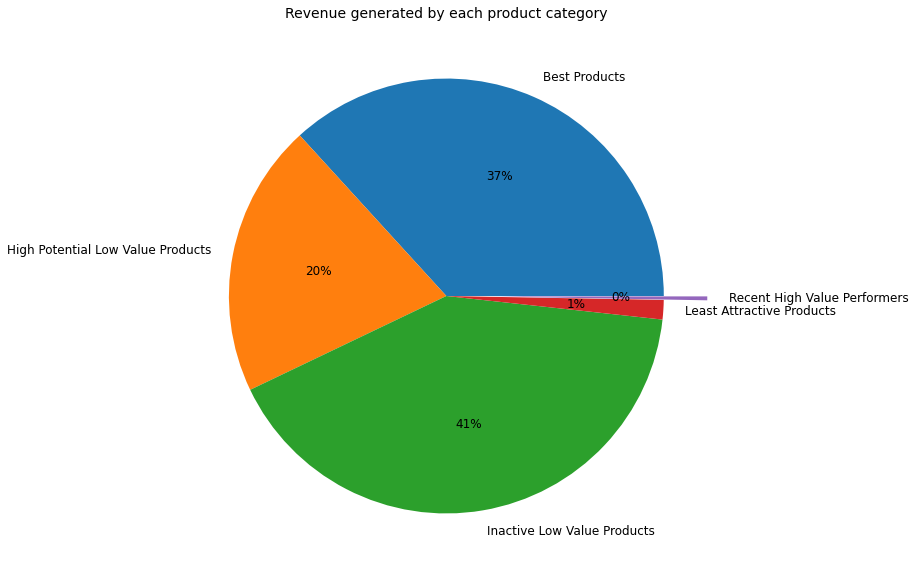

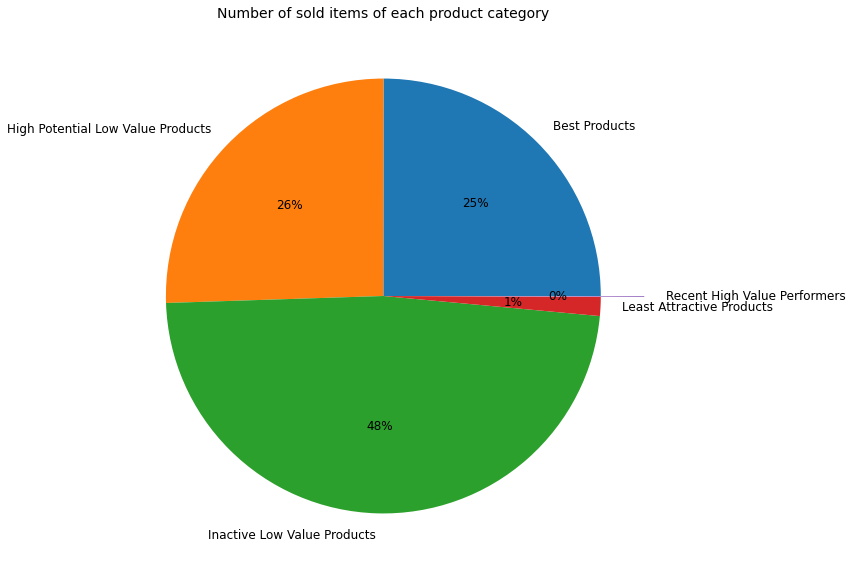

,RFM_category,Quantity,revenue
0,Best Products,1009996,2912227.170
1,High Potential Low Value Products,1031544,1609460.210
2,Inactive Low Value Products,1940638,3259978.044
3,Least Attractive Products,57002,114250.240
4,Recent High Value Performers,2507,22714.810


In [106]:
for_pie = sold.groupby('RFM_category').agg({'Quantity':'sum','revenue':'sum'}).reset_index().sort_index()

plt.figure(figsize = (15,10))
explode = [0, 0, 0, 0, .2]
plt.pie(for_pie['revenue'], labels = for_pie['RFM_category'], textprops={'fontsize':12}, explode=explode, autopct='%.0f%%')
plt.title('Revenue generated by each product category', fontsize = 14)
plt.show()

plt.figure(figsize = (15,10))
explode = [0, 0, 0, 0, .2]
plt.pie(for_pie['Quantity'], labels = for_pie['RFM_category'], textprops={'fontsize':12}, explode=explode, autopct='%.0f%%')
plt.title('Number of sold items of each product category', fontsize = 14)
plt.show()

display(for_pie)

### Conclusion

* `Inactive Low Value Products`, whic are 74% of all assortiment in the store, generate 41% of all revenue and are 48% of all sold items, because of their big number presented.
* The `Best products`, which are only 4% of all assortiment in the store, generate 37% of all revenue and are 25% of all sold items - they are really the backbone of the store's income
* `	High Potential Low Value Products`, which are 7% of the store's assortiment, generate 20% of the revenue and are 26% pf all items sold
* `Least attractive products`, which are 14% of all store's assortiment, generate only 1% of the revenue and are 1% of all sold items - indeed, they may be dropped from the store, creating space for more interesting products, and it won't affect the store's income.

## Sales and revenue generation of products from different categories throughout the year

* **Revenue generation across the year**

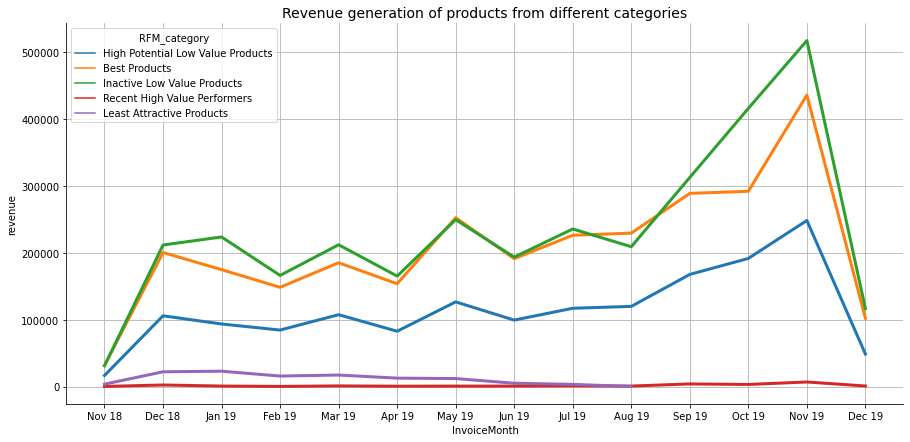

In [107]:
for_lineplot = sold.groupby(['InvoiceMonth','RFM_category']).agg({'revenue':'sum','Quantity':'sum','InvoiceDate':'min'}).sort_values(by = 'InvoiceDate')

plt.figure(figsize = (15,7))
sns.lineplot(data = for_lineplot, x = 'InvoiceMonth', y = 'revenue',hue = 'RFM_category',linewidth=3)
sns.despine()
plt.grid()
plt.title('Revenue generation of products from different categories', fontsize = 14)
plt.show()

The `Best`, `Inactive Low Value` and `High Potential Low Value Products` have the same pattern, with the peak in may and a rise from August to the maximum in November. 

However, `Least attractive` products generated revenue only until August, after which they stopped.

* **Sales across the year**

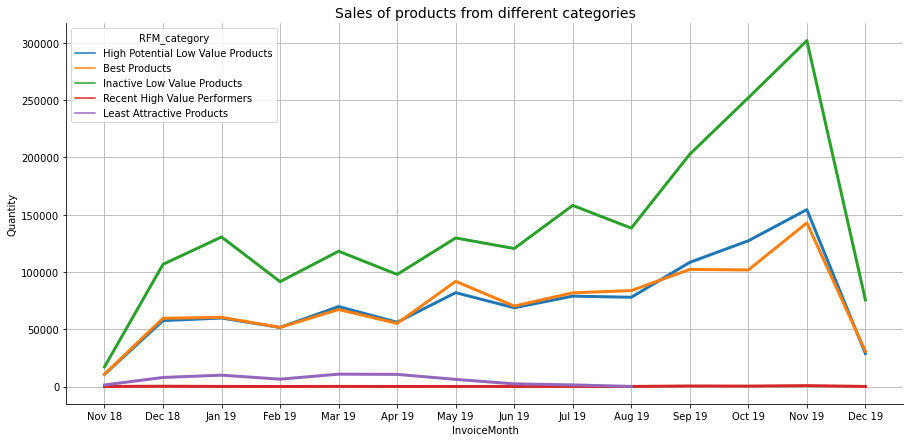

In [108]:
plt.figure(figsize = (15,7))
sns.lineplot(data = for_lineplot, x = 'InvoiceMonth', y = 'Quantity',hue = 'RFM_category',linewidth=3)
sns.despine()
plt.grid()
plt.title('Sales of products from different categories', fontsize = 14)
plt.show()

The same is for products selling, except for the peak in may, that is not pronounced for `Inactive Low Value Products`.

### Conclusion

One interesting observation can be done here:

On the one hand, revenue generation of `Inactive Low Value` and `Best` products is exactly the same in terms of value and pattern, while the pattern of `High potential Low Value` products is the same too, but the value is approx 2-times less.

On the other hand, the number of sold items and the pattern of selling during the year is similar in `High potential Low Value` and `Best` products, while the `Inactive Low value` products show the same pattern, but the number of items is approx 2-times more.

# Statistical hypotheses testing
## Does the color affect the item's sellability?
|
In order to find out, if the color affect the sellability of the item firstly I will create the subset with prosucts' descriptions and their quantities

In [109]:
colored_items = sold.groupby('Description').agg({'Quantity':'sum'}).reset_index()

Than, I will apply the tokenization and filter out the color keywords:

In [110]:
# Tokenization:

colored_items['Description'] = colored_items['Description'].str.lower()
colored_items['Description'] = colored_items['Description'].str.replace('[^\w\s]', '')  # remove special characters

colored_items['tokens'] = colored_items['Description'].apply(word_tokenize)

#List of the colors:
colors = ['red','green','white','cream','orange','blue','pink','brown','ivory','purple','black', 'yellow']

# Empty column for color:
colored_items['color']=0

In [111]:
# Searching the color in every token list and adding it to the preparied column:
for i in range(len(colored_items)):
    for word in colored_items['tokens'][i]:
        if word in colors:
            colored_items['color'][i] = word
            colored_items['tokens'][i].remove(word)

In [112]:
colored_items.head(10)

,Description,Quantity,tokens,color
0,4 purple flock dinner candles,142,"[4, flock, dinner, candles]",purple
1,50s christmas gift bag large,1539,"[50s, christmas, gift, bag, large]",0
2,dolly girl beaker,1034,"[dolly, girl, beaker]",0
3,i love london mini backpack,388,"[i, love, london, mini, backpack]",0
4,nine drawer office tidy,54,"[nine, drawer, office, tidy]",0
5,oval wall mirror diamante,201,"[oval, wall, mirror, diamante]",0
6,red spot gift bag large,1404,"[spot, gift, bag, large]",red
7,set 2 tea towels i love london,3643,"[set, 2, tea, towels, i, love, london]",0
8,spaceboy baby gift set,481,"[spaceboy, baby, gift, set]",0
9,toadstool bedside light,251,"[toadstool, bedside, light]",0


Filtering out rows, where was no color mentioned:

In [113]:
colored_items = colored_items[colored_items['color']!=0]
colored_items.head(10)

,Description,Quantity,tokens,color
0,4 purple flock dinner candles,142,"[4, flock, dinner, candles]",purple
6,red spot gift bag large,1404,"[spot, gift, bag, large]",red
16,12 ivory rose peg place settings,968,"[12, rose, peg, place, settings]",ivory
19,12 pencils small tube red retrospot,4761,"[12, pencils, small, tube, retrospot]",red
22,12 pencils tall tube red retrospot,2616,"[12, pencils, tall, tube, retrospot]",red
25,12 pink henchicks in basket,41,"[12, henchicks, in, basket]",pink
26,12 pink rose peg place settings,214,"[12, rose, peg, place, settings]",pink
27,12 red rose peg place settings,448,"[12, rose, peg, place, settings]",red
28,15 pink fluffy chicks in box,10,"[15, fluffy, chicks, in, box]",pink
38,200 red white bendy straws,881,"[200, white, bendy, straws]",red


In [114]:
colored_items.color.value_counts()

pink      279
blue      201
red       184
white     114
green      96
black      95
ivory      60
cream      42
purple     35
yellow     17
brown      13
orange      9
Name: color, dtype: int64

I will use white for ivory and cream items to make this category bigger and will drop purple, brown and orange colors, as there is too few of them:

In [115]:
colored_items = colored_items.reset_index(drop = True)
for i in range(len(colored_items)):
    if colored_items['color'][i] == 'ivory' or colored_items['color'][i] == 'cream':
        colored_items['color'][i] = 'white'
        
colored_items = colored_items[~colored_items['color'].isin(['purple','brown','orange'])]

In [116]:
colored_items.color.value_counts()

pink      279
white     216
blue      201
red       184
green      96
black      95
yellow     17
Name: color, dtype: int64

Recreating new descriptions without color keywords from updated tokens lists:

In [117]:
def descr(row):
    return ' '.join(row)

colored_items['Description'] = colored_items['tokens'].apply(descr)

Now filtering out only those items, that have identical "colorless" descriptions with available color options more than 1:

In [118]:
for description in colored_items['Description'].unique():
    if len(colored_items[colored_items['Description'] == description]) == 1:
        colored_items = colored_items[colored_items['Description'] != description]

Now the dataset is prepaired and looks like that:

In [119]:
colored_items[colored_items.Description == 'alarm clock bakelike'][['Description','Quantity','color']].head(20)

,Description,Quantity,color
37,alarm clock bakelike,5473,green
38,alarm clock bakelike,2496,white
40,alarm clock bakelike,3663,pink
41,alarm clock bakelike,5870,red


Now everything is ready for the test, it will be done by function with Mann-Whitney test inside it.

This will take a particular color option, calculating the share of items bought in this color and shares of them bought in other colors. This will create inequal distributions of shares, with the target color sample being smaller, than other. Still this may reveal some interesting results:

In [120]:
def color_driven_sells(color_of_interest):
    # Taking items with the color option of interest:
    items_with_color_option = pd.DataFrame(columns=['color', 'proportion'])
    i = 0
    for item in colored_items['Description'].unique():
        items = colored_items[(colored_items['Description'] == item)]
        if color_of_interest in items['color'].unique():
            i += 1
    # Calculating the proportins of each color option bought for each product:
            items['Quantity_all'] = items['Quantity'].sum()
            items['proportion'] = items.Quantity/items.Quantity_all
            items = items[['color','proportion']]
            items_with_color_option = items_with_color_option.append(items)
    items_with_color_option['proportion'] = items_with_color_option['proportion'].astype(float)
    
    #creating arrays of proportions of color of interest and other color options:
    color_of_interest_props = items_with_color_option[items_with_color_option['color'] == color_of_interest]['proportion']
    other_colors_props = items_with_color_option[~(items_with_color_option['color'] == color_of_interest)]['proportion']
    
    print(f'There are {i} items in the dataset, which have {color_of_interest} color option among others')
    
    # Visualizing the distributions of the proportions for different colors:
    plt.figure(figsize=(15,7))
    sns.histplot(data = color_of_interest_props, alpha = .3, color = 'orange')
    sns.histplot(data = other_colors_props, alpha = .3, color = 'blue')
    other = mpatches.Patch(color='lightblue', label='other color options')
    inter = mpatches.Patch(color='orange', label=f'{color_of_interest}-colored items')
    plt.legend(handles=[inter,other])
    sns.despine()
    plt.title(f'Proportions of each item bought in {color_of_interest} vs other color options for this item', fontsize = 14)
    plt.grid()
    plt.show()
    
    # Mean proportions' calculation and hypothses stating:
    print(f'{np.round(np.mean(color_of_interest_props),3)} is the mean proportion of the {color_of_interest} items bought for each product with this color option')
    print(f'{np.round(np.mean(other_colors_props),3)} is the mean proportion of the items bought in other colors for each product with the {color_of_interest} color option')
    print()
    print(f'Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from')
    print(f'Alternative Hypothesis: people do prefer to buy items in {color_of_interest} color if there are other color options to choose from')
    print()
    
    # Statistical test application:
    stat,p = scipy.stats.mannwhitneyu(color_of_interest_props,other_colors_props)
    
    # Bonferroni correction for the alpha level:
    alpha = 0.005/(len(colored_items['color'].unique()))
    
    if p > alpha:
        print('We can\'t reject the Null hypothesis, p-value is:',round(p,4))
    else:
        print('We can reject the null hypothesis, p-value is:',round(p,4))
    print()
    print('= '*60)

Applying the function for all the colors:


Studying white-colored items sellability

There are 71 items in the dataset, which have white color option among others


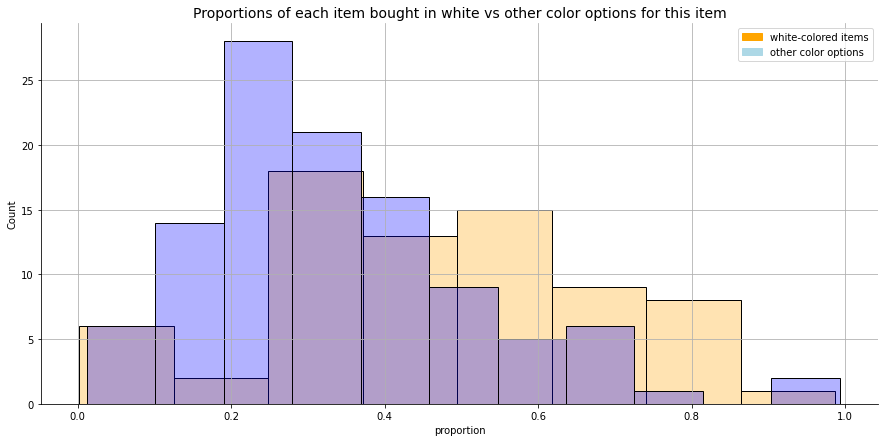

0.473 is the mean proportion of the white items bought for each product with this color option
0.342 is the mean proportion of the items bought in other colors for each product with the white color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in white color if there are other color options to choose from

We can reject the null hypothesis, p-value is: 0.0

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Studying pink-colored items sellability

There are 123 items in the dataset, which have pink color option among others


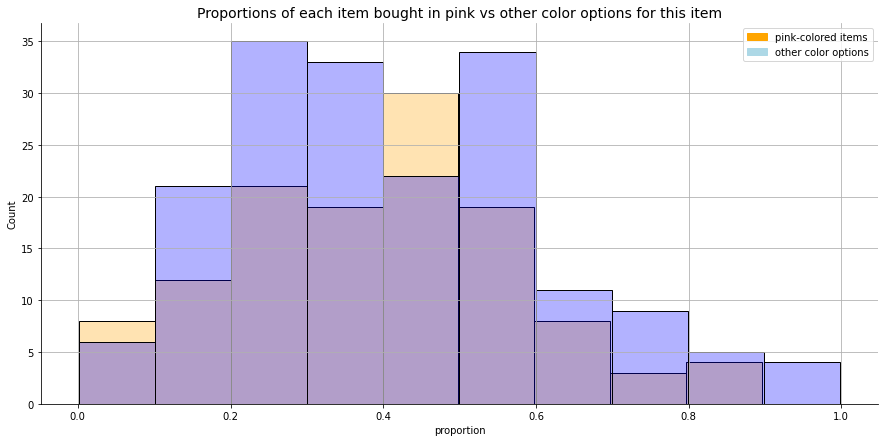

0.391 is the mean proportion of the pink items bought for each product with this color option
0.414 is the mean proportion of the items bought in other colors for each product with the pink color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in pink color if there are other color options to choose from

We can't reject the Null hypothesis, p-value is: 0.5064

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Studying red-colored items sellability

There are 73 items in the dataset, which have red color option among others


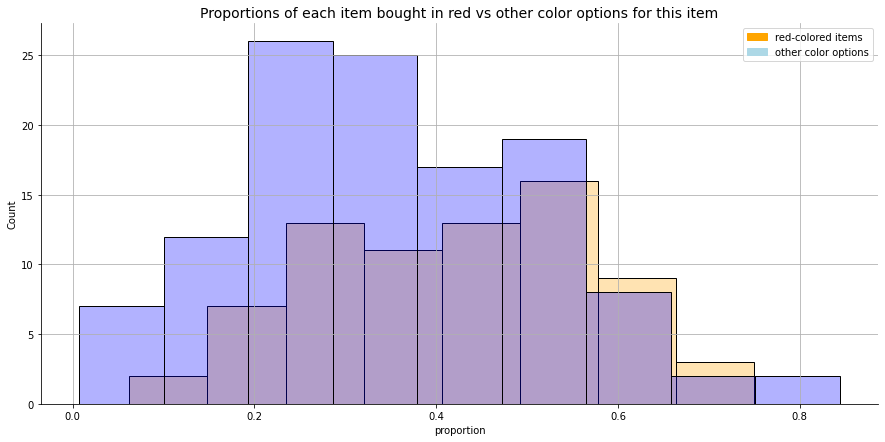

0.423 is the mean proportion of the red items bought for each product with this color option
0.354 is the mean proportion of the items bought in other colors for each product with the red color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in red color if there are other color options to choose from

We can't reject the Null hypothesis, p-value is: 0.0046

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Studying blue-colored items sellability

There are 97 items in the dataset, which have blue color option among others


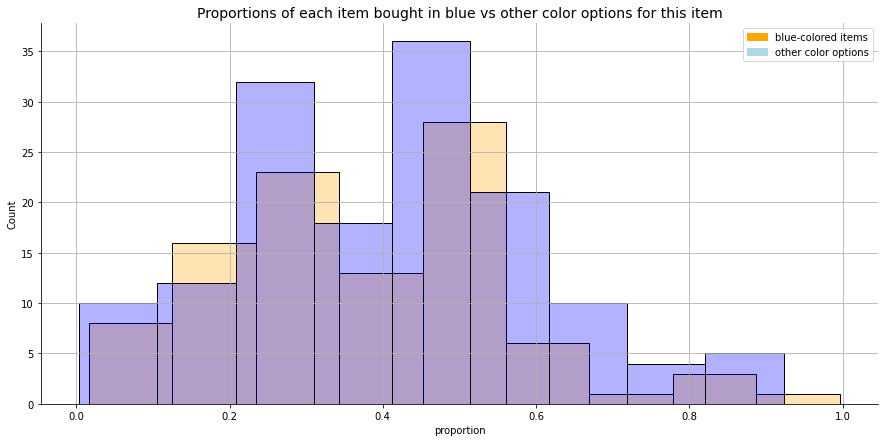

0.375 is the mean proportion of the blue items bought for each product with this color option
0.404 is the mean proportion of the items bought in other colors for each product with the blue color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in blue color if there are other color options to choose from

We can't reject the Null hypothesis, p-value is: 0.2193

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Studying black-colored items sellability

There are 37 items in the dataset, which have black color option among others


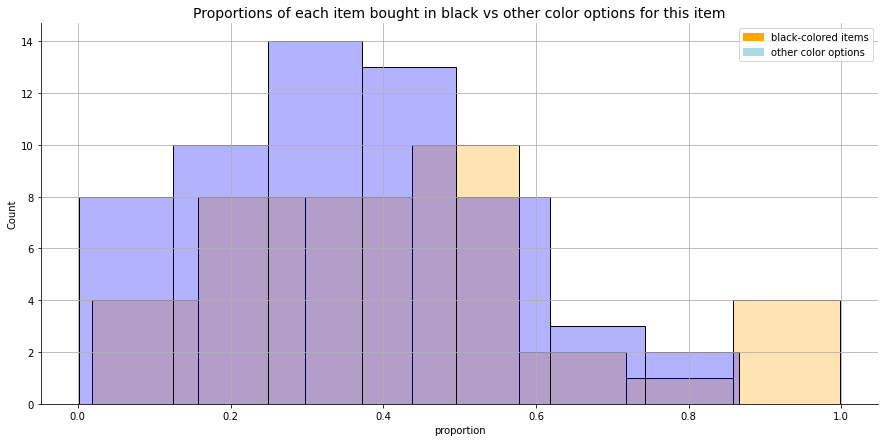

0.446 is the mean proportion of the black items bought for each product with this color option
0.353 is the mean proportion of the items bought in other colors for each product with the black color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in black color if there are other color options to choose from

We can't reject the Null hypothesis, p-value is: 0.1671

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Studying green-colored items sellability

There are 64 items in the dataset, which have green color option among others


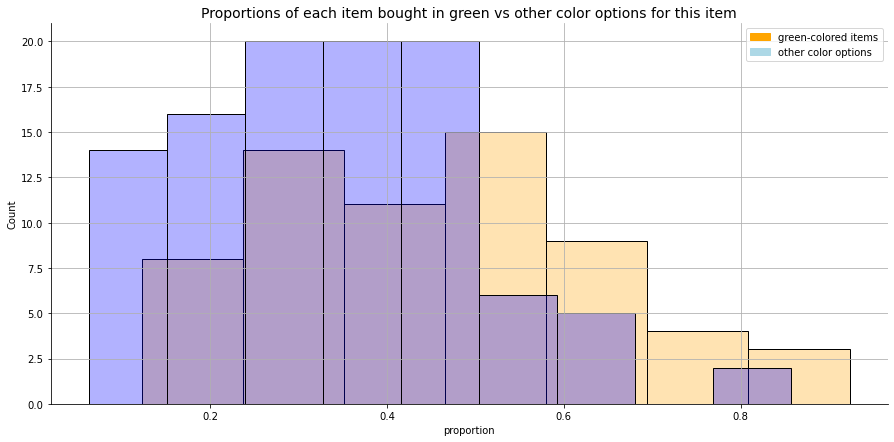

0.452 is the mean proportion of the green items bought for each product with this color option
0.34 is the mean proportion of the items bought in other colors for each product with the green color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in green color if there are other color options to choose from

We can reject the null hypothesis, p-value is: 0.0003

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Studying yellow-colored items sellability

There are 12 items in the dataset, which have yellow color option among others


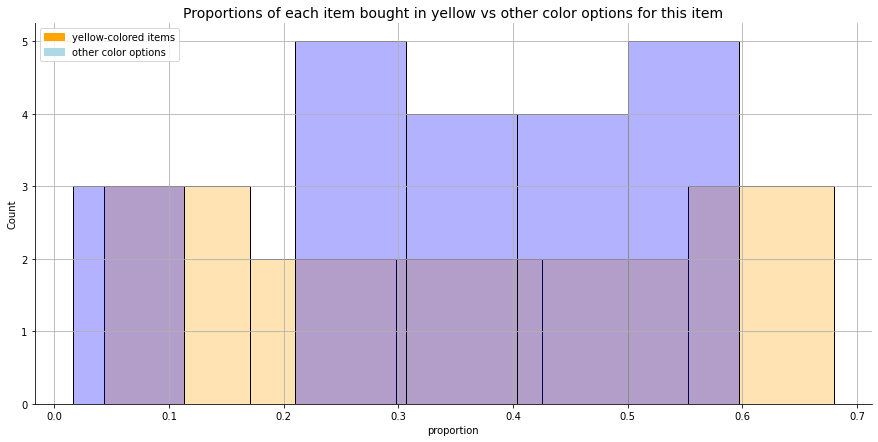

0.378 is the mean proportion of the yellow items bought for each product with this color option
0.355 is the mean proportion of the items bought in other colors for each product with the yellow color option

Null Hypothesis: people buy items in different colors with equal frequancy, if there are color options to choose from
Alternative Hypothesis: people do prefer to buy items in yellow color if there are other color options to choose from

We can't reject the Null hypothesis, p-value is: 0.6944

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [121]:
for color in colored_items['color'].unique():
    print()
    print('\033[1m' + f'Studying {color}-colored items sellability')
    print()
    color_driven_sells(color)

### Conclusion

We can reject the Null-hypotheses for two colors: white and green. Seems like customers prefer buying products in this color, if the chosen item has this and other color options.

## Does price affect sellability?

For this task I will calculate Pearson and Spearman correlation coefficients and use the Linear regression model.

In [122]:
def correlation(df):
    plt.figure(figsize = (10,10))
    sns.regplot(x='UnitPrice', y='Quantity', data=df)
    plt.title('Regplot of sellability dependance on price')
    plt.show()

    pearson_corr = df['Quantity'].corr(df['UnitPrice'], method='pearson')
    print('Pearson correlation coefficient:', pearson_corr)

    spearman_corr = df['Quantity'].corr(df['UnitPrice'], method='spearman')
    print('Spearman rank correlation coefficient:', spearman_corr)
    
    print('*'*80)
    
    X = df['UnitPrice']
    y = df['Quantity']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print(model.summary())

* **All products**

For this new subset should be created with quantity of bought items and their price. I will take the median Unit price here, as there may be differences between stated prices for similar products:

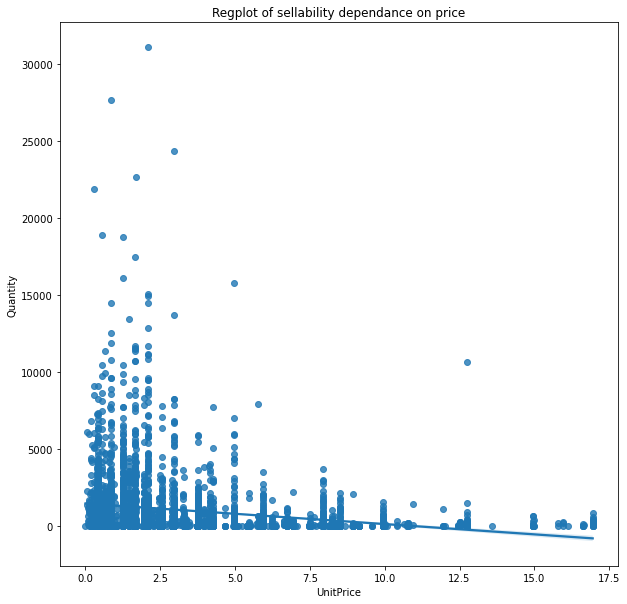

Pearson correlation coefficient: -0.19457365395788875
Spearman rank correlation coefficient: -0.35585488570991874
********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     147.1
Date:                Tue, 09 May 2023   Prob (F-statistic):           3.14e-33
Time:                        22:38:46   Log-Likelihood:                -33762.
No. Observations:                3740   AIC:                         6.753e+04
Df Residuals:                    3738   BIC:                         6.754e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
               

In [123]:
for_check = sold.groupby('Description').agg({'Quantity':'sum','UnitPrice':'median'})
correlation(for_check)

Data Is quite noisy. Some products seems to have a true correlation, as there are bunch of cheap good-selling ones and also bunch of expensice ones with low sellings. But a lot of products with low price and low sellings interfere this picture. Correlation coefficients are weak. Let's see, what Linear regression will tell us 

The output indicates that there is a significant relationship between price and sellability, based on the P>|t| values. In this case, the p-value for the UnitPrice coefficient is very small (close to zero), which means that we can reject the null hypothesis that the coefficient is equal to zero, and conclude that there is a significant effect of UnitPrice on the Quantity sold.

One important factor is the R-squared value, which in this case is 0.038. This indicates that only about 3.8% of the variation in the Quantity sold can be explained by the variation in UnitPrice. While this is a small amount of variation, it is still statistically significant.

Another factor to consider is the normality of the residuals. We can check this by looking at the Omnibus and Jarque-Bera tests, which are tests of normality of the residuals. In this case, both tests have very small p-values, which suggests that the residuals are not normally distributed. This could indicate that there are other factors influencing the Quantity sold that are not captured in the model.

Additionally, we can look at the Durbin-Watson statistic, which tests for autocorrelation of the residuals. In this case, the value is 1.457, which is close to 2 (the ideal value for no autocorrelation), suggesting that there is no significant autocorrelation in the residuals.

Overall, while the analysis shows a significant effect of UnitPrice on Quantity sold for 3.8% of products, there are definitly limitations to the model that should be considered when interpreting the results.

* **Best Products**

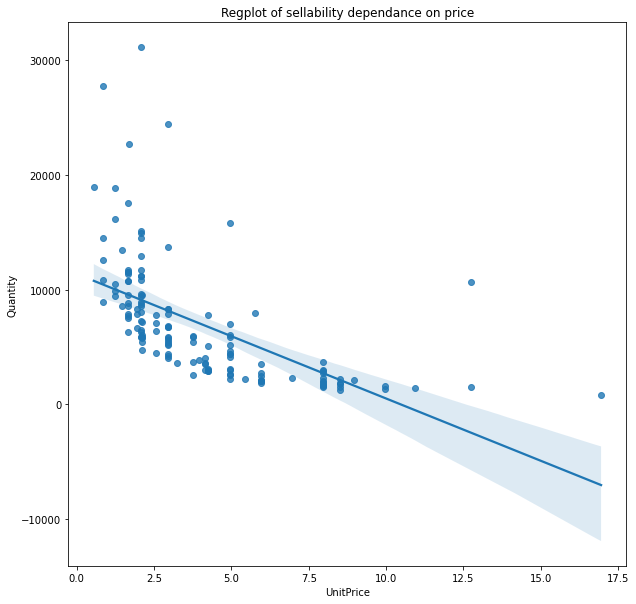

Pearson correlation coefficient: -0.5797331260675325
Spearman rank correlation coefficient: -0.8373295929891761
********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     71.88
Date:                Tue, 09 May 2023   Prob (F-statistic):           2.67e-14
Time:                        22:38:46   Log-Likelihood:                -1408.0
No. Observations:                 144   AIC:                             2820.
Df Residuals:                     142   BIC:                             2826.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

In [124]:
for_check = sold[sold['RFM_category']=='Best Products'].groupby('Description').agg({'Quantity':'sum','UnitPrice':'median'})
correlation(for_check)

For this group of products correlation coefficients are better, the Spearman coefficient is -0.83, which may indicate strong dependance. But, plot reveals again the same problem - there is a bunch of items, that do not follow the dependance.

In this case, an R-squared value of 0.336 suggests that there is some relationship between the price and the sellability, but other factors may also be influencing the quantity sold.

The p-value for the UnitPrice variable is less than 0.05, which means that the coefficient for UnitPrice is statistically significant. This indicates that there is a relationship between price and sellability, as an increase in price is associated with a decrease in the quantity sold.

The F-statistic value of 71.88 with a corresponding p-value of 2.67e-14 suggests that the overall regression model is significant and not a result of chance. This means that the independent variable (price) has a statistically significant relationship with the dependent variable (quantity sold).

* **Least Attractive Products**

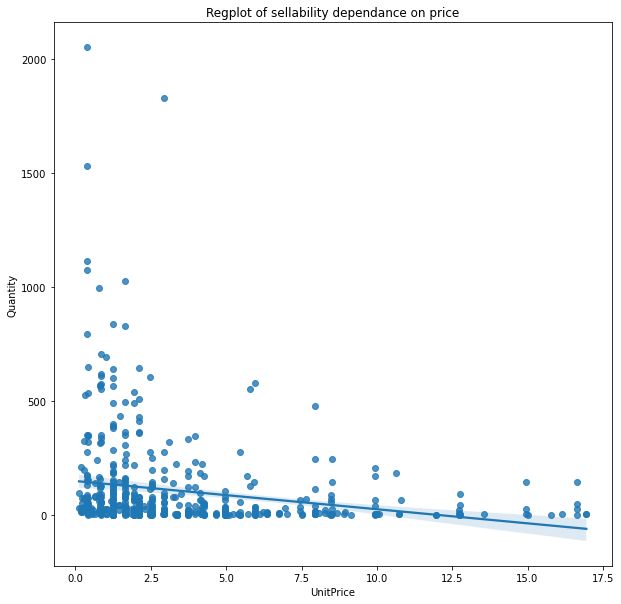

Pearson correlation coefficient: -0.19585403528287898
Spearman rank correlation coefficient: -0.3454830731837635
********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     21.34
Date:                Tue, 09 May 2023   Prob (F-statistic):           4.82e-06
Time:                        22:38:46   Log-Likelihood:                -3629.3
No. Observations:                 537   AIC:                             7263.
Df Residuals:                     535   BIC:                             7271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

In [125]:
for_check = sold[sold['RFM_category']=='Least Attractive Products'].groupby('Description').agg({'Quantity':'sum','UnitPrice':'median'})
correlation(for_check)

This group has low both correlation coefficients and looks quite noisy. The problem here is the same as for the sample with whole assortiment of this store: judgibg on R-squared value only 3.8% all products sales can be explained by price differances. Again, this result is significant.

* **High Potential Low Value Products**

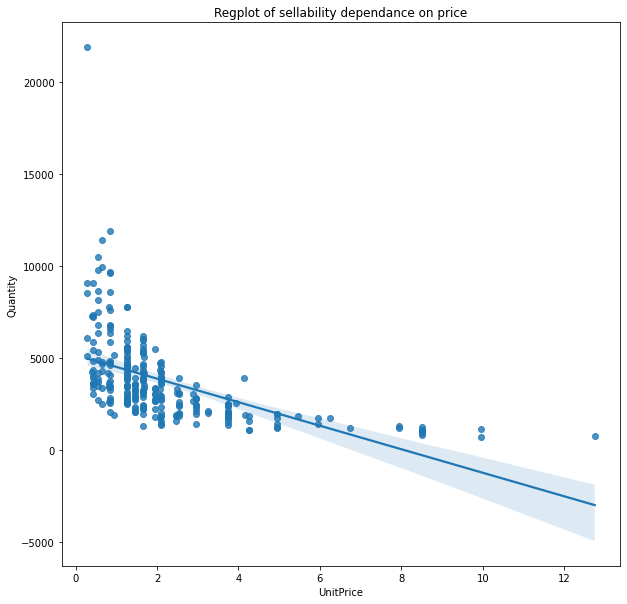

Pearson correlation coefficient: -0.5223787869443459
Spearman rank correlation coefficient: -0.7128471724153902
********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     101.0
Date:                Tue, 09 May 2023   Prob (F-statistic):           2.24e-20
Time:                        22:38:47   Log-Likelihood:                -2440.7
No. Observations:                 271   AIC:                             4885.
Df Residuals:                     269   BIC:                             4893.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

In [126]:
for_check = sold[sold['RFM_category']=='High Potential Low Value Products'].groupby('Description').agg({'Quantity':'sum','UnitPrice':'median'})
correlation(for_check)

For this group quite strong correlation coefficiens were found. Despite this, Regression analysis has revealed only 27% of the data have significant correlation ( R-squared:0.273), but this correlation is true (P>|t|:0.000).

* **Inactive Low Value Products**

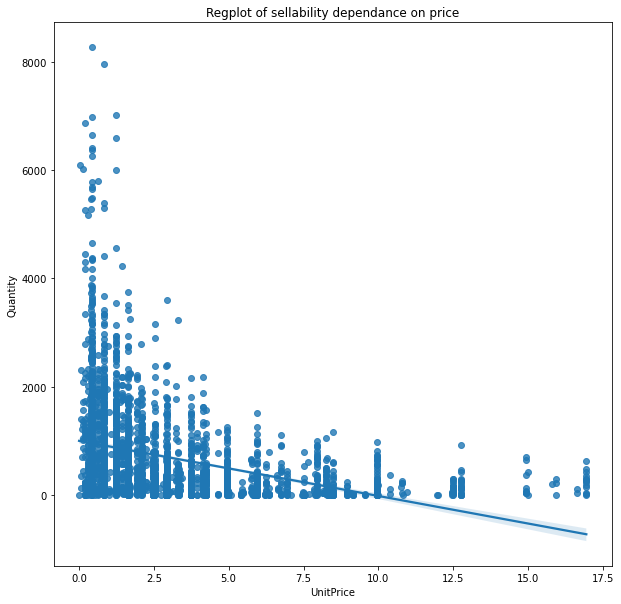

Pearson correlation coefficient: -0.33032018215188663
Spearman rank correlation coefficient: -0.45964511613363246
********************************************************************************
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     341.0
Date:                Tue, 09 May 2023   Prob (F-statistic):           6.51e-72
Time:                        22:38:47   Log-Likelihood:                -22799.
No. Observations:                2786   AIC:                         4.560e+04
Df Residuals:                    2784   BIC:                         4.561e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
               

In [127]:
for_check = sold[sold['RFM_category']=='Inactive Low Value Products'].groupby('Description').agg({'Quantity':'sum','UnitPrice':'median'})
correlation(for_check)

This data is very noisy, both coefficients are smaller than 0.5. R-square statistics says, that only 10.9% of the data is correlated, but again, this cirrelation is signifficant.

### Conclusion

Overall, there are notable correlations between the price of an item and its sellability. This observation is particularly evident in the `Best products` RFM category, where 33.6% of the data exhibits a significant correlation, as well as in the `High Potential Low Value Products` category, where 27.3% of the data shows correlation. The low percentage of the correlated values suggests that when studying sellability, factors beyond price should be taken into consideration.

## Are there any products, that are mostly sold in different season?

I will calculate the shares of each product, that were bought in different seasons and try to clusterize items, based on the sale dynamics during the year by KMeans algorythm.

For it I will extract month's number to a new column and assign the season, when the invoice was done.

In [128]:
sold['month'] = sold['InvoiceDate'].dt.month

In [129]:
def season(row):
    if row in [12,1,2]:
        return 'Winter'
    elif row in [3,4,5]:
        return 'Spring'
    elif row in [6,7,8]:
        return 'Summer'
    else:
        return 'Fall'

In [130]:
sold['Season'] = sold['month'].apply(season)

Grouping items by their `Description` and `Season` with calculating of the amount of bought items:

In [131]:
sold_grouped = sold.groupby(['Description','Season'])['Quantity'].sum().reset_index()
sold_grouped.head()

,Description,Season,Quantity
0,4 PURPLE FLOCK DINNER CANDLES,Fall,60
1,4 PURPLE FLOCK DINNER CANDLES,Spring,10
2,4 PURPLE FLOCK DINNER CANDLES,Summer,6
3,4 PURPLE FLOCK DINNER CANDLES,Winter,66
4,50'S CHRISTMAS GIFT BAG LARGE,Fall,1463


Calculating the full amount of each product, sold during the whole period:

In [132]:
sold_grouped2 = sold_grouped.groupby('Description')['Quantity'].sum().reset_index()
sold_grouped2 = sold_grouped2.set_index('Description').to_dict()['Quantity']

Creating new column with the share of each product's quantity sold in different seasons.

In [133]:
sold_grouped['Total sold'] = sold_grouped['Description'].map(sold_grouped2)
sold_grouped['Share'] = sold_grouped['Quantity']/sold_grouped['Total sold']
sold_grouped.head()

,Description,Season,Quantity,Total sold,Share
0,4 PURPLE FLOCK DINNER CANDLES,Fall,60,142,0.422535
1,4 PURPLE FLOCK DINNER CANDLES,Spring,10,142,0.070423
2,4 PURPLE FLOCK DINNER CANDLES,Summer,6,142,0.042254
3,4 PURPLE FLOCK DINNER CANDLES,Winter,66,142,0.464789
4,50'S CHRISTMAS GIFT BAG LARGE,Fall,1463,1539,0.950617


Creating a pivot table with `Description` as index and season sales share as columns:

In [134]:
pivot = sold_grouped.pivot_table(index='Description', columns='Season', values='Share').fillna(0)
pivot.head()

Season,Fall,Spring,Summer,Winter
Description,,,,
4 PURPLE FLOCK DINNER CANDLES,0.422535,0.070423,0.042254,0.464789
50'S CHRISTMAS GIFT BAG LARGE,0.950617,0.000000,0.024691,0.024691
DOLLY GIRL BEAKER,0.542553,0.000000,0.412959,0.044487
I LOVE LONDON MINI BACKPACK,0.935567,0.000000,0.000000,0.064433
NINE DRAWER OFFICE TIDY,0.870370,0.000000,0.000000,0.129630


Applying the automated algorythm, that cluster items into 2-6 clusters with calculating the best silhouette score:

In [135]:
score={}
for n_cluster in [2,3,4,5,6]:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(pivot)
    silhouette_avg = silhouette_score(pivot,kmeans.labels_)
    score[n_cluster]=silhouette_avg
    needed_number=max(score,key=score.get)
print(score)
print(f'The best silhouette_score is for {needed_number} clusters')

{2: 0.3386350888069779, 3: 0.3773642935286532, 4: 0.3972575947837176, 5: 0.4048339892992373, 6: 0.3455557811933559}
The best silhouette_score is for 5 clusters


Silhouette score for 5 clusters is not very good, only 0.4. Still, it may give some inetersting results.

Applying clustering algorythm for 5 clusters.

In [136]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(pivot)
pivot['Cluster'] = kmeans.labels_
pivot = pivot.reset_index()

In [137]:
pivot['Cluster'].value_counts()

1    1659
2     723
3     552
4     418
0     388
Name: Cluster, dtype: int64

Visualization of gained clusters:

Shares of products clusters, that were sold in different seasons


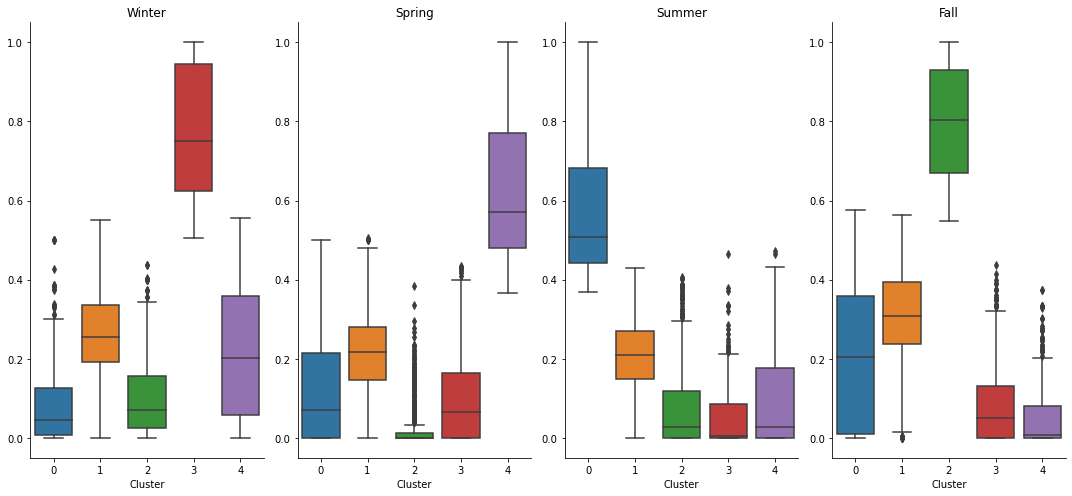

In [138]:
print('\033[1m' + 'Shares of products clusters, that were sold in different seasons')
fig, axs = plt.subplots(ncols=4, figsize = (15,7))
seasons = ['Winter','Spring','Summer','Fall']
for i in range(4):
    sns.boxplot(x='Cluster', y=seasons[i], data=pivot, ax=axs[i])
    axs[i].set_ylabel('')    
    axs[i].set_title(seasons[i]) 
    plt.tight_layout()
    sns.despine()

5  clusters are observed here:
* 0 - items that are sold best in Summer. It is well defined, so may be considered as true one.
* 1 - items without observable seasonal sales peak
* 2 - items, that are best-sold in Fall, again, this cluster is well pronounced
* 3 - items, that are best-sold in Winter
* 4 - items, that are best-sold in Spring

Althought the silhouette score is quite low, obtained clusters are quite well-defined, so the results seems like trustworthy.

In [139]:
for i in range(5):
    print(f'Items examples from cluster {i}')
    display(pivot[pivot['Cluster']==i]['Description'].head(10))
    print('*'*70)

Items examples from cluster 0


2                      DOLLY GIRL BEAKER
9               TOADSTOOL BEDSIDE LIGHT 
21             12 PENCILS TALL TUBE POSY
30    16 PIECE CUTLERY SET PANTRY DESIGN
31    18PC WOODEN CUTLERY SET DISPOSABLE
37                200 BENDY SKULL STRAWS
39                 3 BIRDS CANVAS SCREEN
59                  36 PENCILS TUBE POSY
62              36 PENCILS TUBE WOODLAND
65    3D HEARTS  HONEYCOMB PAPER GARLAND
Name: Description, dtype: object

**********************************************************************
Items examples from cluster 1


0           4 PURPLE FLOCK DINNER CANDLES
5              OVAL WALL MIRROR DIAMANTE 
7         SET 2 TEA TOWELS I LOVE LONDON 
8                  SPACEBOY BABY GIFT SET
11                 10 COLOUR SPACEBOY PEN
12             12 COLOURED PARTY BALLOONS
14              12 EGG HOUSE PAINTED WOOD
17        12 MESSAGE CARDS WITH ENVELOPES
19    12 PENCILS SMALL TUBE RED RETROSPOT
20            12 PENCILS SMALL TUBE SKULL
Name: Description, dtype: object

**********************************************************************
Items examples from cluster 2


1           50'S CHRISTMAS GIFT BAG LARGE
3             I LOVE LONDON MINI BACKPACK
4                 NINE DRAWER OFFICE TIDY
6                 RED SPOT GIFT BAG LARGE
10                      TRELLIS COAT RACK
15           12 HANGING EGGS HAND PAINTED
18          12 PENCIL SMALL TUBE WOODLAND
23            12 PENCILS TALL TUBE SKULLS
29    15CM CHRISTMAS GLASS BALL 20 LIGHTS
32                    2 DAISIES HAIR COMB
Name: Description, dtype: object

**********************************************************************
Items examples from cluster 3


47           3 PINK HEN+CHICKS IN BASKET
56        3 WICK CHRISTMAS BRIAR CANDLE 
66              3D SHEET OF CAT STICKERS
72          4 GOLD FLOCK CHRISTMAS BALLS
84         5 HOOK HANGER MAGIC TOADSTOOL
99           6 RIBBONS SHIMMERING PINKS 
107            75 BLACK PETIT FOUR CASES
117               ACRYLIC GEOMETRIC LAMP
127             AFGHAN SLIPPER SOCK PAIR
145    AMBER BERTIE GLASS BEAD BAG CHARM
Name: Description, dtype: object

**********************************************************************
Items examples from cluster 4


13               12 DAISY PEGS IN WOOD BOX
16        12 IVORY ROSE PEG PLACE SETTINGS
25            12 PINK HEN+CHICKS IN BASKET
26         12 PINK ROSE PEG PLACE SETTINGS
28            15 PINK FLUFFY CHICKS IN BOX
33        2 PICTURE BOOK EGGS EASTER BUNNY
34       2 PICTURE BOOK EGGS EASTER CHICKS
35        2 PICTURE BOOK EGGS EASTER DUCKS
85       5 HOOK HANGER RED MAGIC TOADSTOOL
103    60 GOLD AND SILVER FAIRY CAKE CASES
Name: Description, dtype: object

**********************************************************************


### Conclusion

KMeans algorythm has revealed 5 product clusters, that are well-defined in terms of seanson, in which they were mostly bought. 4 of them has peaks in different seasons, while another one stays on "background" level throughout the year.

This information should help to prepare stocks for the seasonal sales variations, but should not be considered as indisputable truth

## Are there any products, that are mostly sold in different time of the day?

Here I will use the same logic as for seasonality, but will group items by the time of the day with the function:

In [140]:
def daytime(row):
    if int(row) in [6,7,8,9,10]:
        return 'Morning'
    elif int(row) in [11,12,13,14,15]:
        return 'Day'
    else:
        return 'Evening'

In [141]:
sold['Time_of_day'] = sold['InvoiceHourOfDay'].apply(daytime)

Preparing a pivot table:

In [142]:
sold_grouped = sold.groupby(['Description','Time_of_day'])['Quantity'].sum().reset_index()
sold_grouped2 = sold_grouped.groupby('Description')['Quantity'].sum().reset_index()
sold_grouped2 = sold_grouped2.set_index('Description').to_dict()['Quantity']
sold_grouped['Total sold'] = sold_grouped['Description'].map(sold_grouped2)
sold_grouped['Share'] = sold_grouped['Quantity']/sold_grouped['Total sold']
pivot = sold_grouped.pivot_table(index='Description', columns='Time_of_day', values='Share').fillna(0)
pivot.head()

Time_of_day,Day,Evening,Morning
Description,,,
4 PURPLE FLOCK DINNER CANDLES,0.591549,0.056338,0.352113
50'S CHRISTMAS GIFT BAG LARGE,0.789474,0.073424,0.137102
DOLLY GIRL BEAKER,0.705029,0.088975,0.205996
I LOVE LONDON MINI BACKPACK,0.579897,0.051546,0.368557
NINE DRAWER OFFICE TIDY,0.814815,0.018519,0.166667


In [143]:
score={}
for n_cluster in [2,3,4,5,6]:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(pivot)
    silhouette_avg = silhouette_score(pivot,kmeans.labels_)
    score[n_cluster]=silhouette_avg
    needed_number=max(score,key=score.get)
print(score)
print(f'The best silhouette_score is for {needed_number} clusters')

{2: 0.577652526672911, 3: 0.41121595810665196, 4: 0.45847195394975915, 5: 0.45738066787756765, 6: 0.37984580079060254}
The best silhouette_score is for 2 clusters


Now silhouette score is better: 0.57, so this results should be more reliable, which is less logical:

In [144]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pivot)
pivot['Cluster'] = kmeans.labels_
pivot = pivot.reset_index()
pivot['Cluster'].value_counts()

0    3320
1     420
Name: Cluster, dtype: int64

Visualization:

Shares of products clusters, that were sold in different seasons


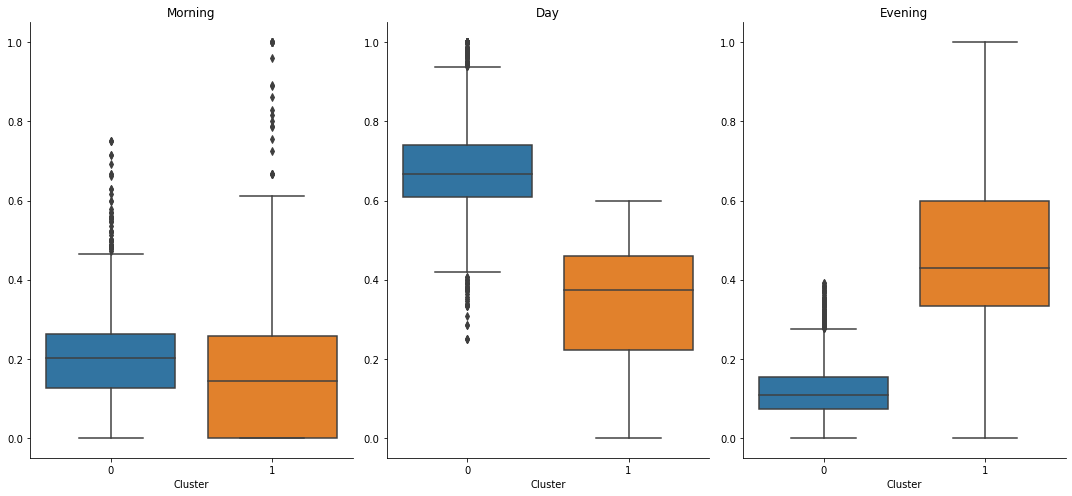

In [145]:
print('\033[1m' + 'Shares of products clusters, that were sold in different seasons')
fig, axs = plt.subplots(ncols=3, figsize = (15,7))
daytime = ['Morning','Day','Evening']
for i in range(3):
    sns.boxplot(x='Cluster', y=daytime[i], data=pivot, ax=axs[i])
    axs[i].set_ylabel('')    
    axs[i].set_title(daytime[i]) 
    plt.tight_layout()
    sns.despine()

Indeed, there are some products, that are bought mostly in the daytime (cluster 0) and those, that are bought in the evening (cluster 1). The differences are less pronounced, than it was with seasons, but still can used.

In [146]:
pivot['Cluster'].value_counts()

0    3320
1     420
Name: Cluster, dtype: int64

In [147]:
for i in range(2):
    print(f'Items examples from cluster {i}')
    display(pivot[pivot['Cluster']==i]['Description'].head(10))
    print('*'*70)

Items examples from cluster 0


0       4 PURPLE FLOCK DINNER CANDLES
1       50'S CHRISTMAS GIFT BAG LARGE
2                   DOLLY GIRL BEAKER
3         I LOVE LONDON MINI BACKPACK
4             NINE DRAWER OFFICE TIDY
5          OVAL WALL MIRROR DIAMANTE 
6             RED SPOT GIFT BAG LARGE
7     SET 2 TEA TOWELS I LOVE LONDON 
8              SPACEBOY BABY GIFT SET
9            TOADSTOOL BEDSIDE LIGHT 
Name: Description, dtype: object

**********************************************************************
Items examples from cluster 1


32                    2 DAISIES HAIR COMB
39                  3 BIRDS CANVAS SCREEN
49     3 RAFFIA RIBBONS VINTAGE CHRISTMAS
72           4 GOLD FLOCK CHRISTMAS BALLS
86          5 STRAND GLASS NECKLACE AMBER
87       5 STRAND GLASS NECKLACE AMETHYST
107             75 BLACK PETIT FOUR CASES
112              A4 WALL TIDY RED FLOWERS
127              AFGHAN SLIPPER SOCK PAIR
144            AMBER 3 BEAD DROP EARRINGS
Name: Description, dtype: object

**********************************************************************


### Conclusion

KMeans algorythm endeed has found products, that are sold differently in different time of the day, the silhouette score is 0.57. Visualization of this clusters revealed observable, but not really defined differences in treis sales.

The results of this test can be used for items advertisement on the site, but again, it should be used with caution.

# Conclusion
* **Data overview**

The dataset encompasses information regarding sales transactions spanning from November 29, 2018, to December 7, 2019, which accounts for approximately a year, totaling 373 days. It comprises details on 3,758 unique items and has undergone data cleaning, resulting in 535,975 rows.

The prices of products range from 0.001 to 17, with an average price of 3.12.

On average, each item in an invoice has a mean quantity of approximately 8, with a maximum of 100. The mean quantity of all items within a single invoice is 175.

Over the observed period, a total of 514,465 items were sold across 19,330 invoices, while 8,635 items were returned through 3,434 invoices.

There are two noticeable peaks in item sales throughout the year: one in May and another in November. Moreover, a distinct upward trend can be observed from September to November. The revenue generated follows a pattern that closely mirrors the distribution of orders across the year, which is logical.

Friday stands out as the most active day for placing orders, while Monday is the least active. This pattern remains consistent throughout the entire observed period and also applies to returns.

The hour with the highest order activity is 12:00, with the largest number of orders occurring between 10:00 and 15:00. This order dynamics exhibit consistency over the entire observed time period.

The items labeled "Manual" appear among both the 10 worst selling items and the 10 most returned items. Additionally, the products "JUMBO BAG RED RETROSPOT," "LUNCH BAG RED RETROSPOT," and "REGENCY CAKESTAND 3 TIER" feature in both the most purchased and most returned items lists.

Most products exhibit a return rate ranging from 0 to 0.05, with a mean of 0.037 and a median of 0.015. This return rate distribution appears acceptable for an online store. However, there are some products with a return rate exceeding 0.5, with a maximum of 0.86. Such items warrant special attention.

* **Product bundles**

The most popular product, "WHITE HANGING HEART T-LIGHT HOLDER," is frequently purchased alongside other home decor items such as other tea light holders, chalkboards, pictures, and more. Additionally, there are instances where bags are observed to be bought with this particular product.

The most common bundles of products consist of similar types of items. For example, bags are often purchased together with other bags, and sets of teacups and saucers are frequently bought alongside other sets of teacups and saucers.

This suggests that these products can be advertised on each other's pages or offered as bundles on the website. Furthermore, items within the same category, such as home decor, can be suggested on the page of a specific item from that category, given that they are frequently purchased together.

* **RFM Products categories**

Clusterization based on RFM revealed 5 item categories:
* `Inactive Low Value Products`:	2786 items
* `Least Attractive Products`:	537 items
* `High Potential Low Value Products`:	271 items
* `Best Products`:	144 items
* `Recent High Value Performers`:	2 items

Inactive Low Value Products, which make up 74% of the store's assortment, contribute 41% of the total revenue and account for 48% of all items sold. This is primarily due to their large presence in the inventory.

The Best products, comprising only 4% of the store's assortment, generate 37% of the total revenue and represent 25% of all items sold. These products play a crucial role in driving the store's income.

High Potential Low Value Products, making up 7% of the store's assortment, contribute 20% of the revenue and account for 26% of all items sold. Although their value is approximately half that of the Best products, they still demonstrate a similar selling pattern and volume of sales.

On the other hand, the least attractive products, constituting 14% of the store's assortment, generate a mere 1% of the revenue and represent only 1% of all items sold. Considering their negligible contribution to the store's income, these products could potentially be removed to make space for more appealing items without adversely affecting revenue.

From a revenue generation perspective, both Inactive Low Value and Best products exhibit similar patterns in terms of value, while High Potential Low Value products display a similar pattern but with approximately half the value.

In terms of the number of items sold and the selling pattern throughout the year, High Potential Low Value and Best products share similarities, whereas Inactive Low Value products follow a comparable pattern but with approximately twice the number of items sold.

* **Statistical Hypotheses testing**
 * Does color affect sellability?
 
There is strong evidence to suggest that customers have a preference for purchasing products in the colors white and green compared to other color options. This conclusion is supported by the rejection of the null hypothesis, which implies that the equality of color choices does not hold true for these two colors. When given the option to choose from different colors, customers are more inclined to select products available in white and green.

 * Does price affect sellability?
 
In general, there are significant correlations between the price of an item and its sellability. This relationship is particularly evident in two specific categories: the Best products RFM category, where 33.6% of the data shows a significant correlation, and the High Potential Low Value Products category, where 27.3% of the data exhibits correlation. The Spearman and Pearson correlation coefficients range from -0.4 to -0.8, indicating a moderate to strong inverse relationship between price and sellability.

While these findings emphasize the influence of price on sellability, they also highlight the importance of considering additional factors when studying the subject. It is evident that other variables play a role in determining the sellability of products, underscoring the need to analyze a comprehensive set of factors beyond just price. However, the data clearly indicates that price does have a significant impact on the sellability of items.

* Are there any products, that are mostly sold in different season?

The application of the KMeans algorithm has revealed five distinct product clusters, characterized by the seasons in which they were predominantly purchased. Four of these clusters exhibit clear peaks in different seasons, while the remaining cluster remains relatively consistent throughout the year.

The clusters are as follows:

Cluster 1: Consisting of 1,659 items, this cluster demonstrates the highest sales during the summer season. The prominence of this cluster suggests a strong association between these items and summertime purchases.

Cluster 2: Comprising 552 items, this cluster exhibits peak sales during the fall season. The well-defined nature of this cluster indicates a notable preference for these items during autumn.

Cluster 3: With 418 items, this cluster shows the highest sales in the winter season. The distinctness of this cluster indicates a significant correlation between these items and wintertime purchases.

Cluster 4: Including 388 items, this cluster represents products that sell best during the spring season. The presence of a clear peak suggests a seasonal preference for these items during springtime.

Additionally, there is a fifth cluster consisting of 723 items that do not exhibit a discernible seasonal sales peak. These items maintain a relatively consistent level of sales throughout the year.

The information obtained from these clusters can be valuable for inventory management, enabling businesses to better prepare for seasonal sales variations. However, it is important to note that these findings should not be considered as indisputable truth, but rather as insights that can inform decision-making processes regarding stock management.

* Are there any products, that are mostly sold in different time of the day?

The application of the KMeans algorithm has identified two distinct clusters of products based on the time of day they are predominantly purchased. The first cluster consists of 3,320 items that are primarily bought during daytime, while the second cluster comprises 420 items that are predominantly purchased in the evening.

Although the differences between these clusters are less pronounced compared to the seasonal clusters previously mentioned, they can still be utilized for targeted item advertisement on the website. However, it is essential to exercise caution when using this information, as the distinctions between the clusters may not be as strong or reliable as those observed with seasonal patterns. Consideration should be given to potential variations and overlaps in customer preferences, ensuring that any advertising strategies based on these clusters are implemented with prudence.